# Audio Frontend for Xylo-A3

The goal of this notebook is to provide an easy udnerstanding of the various modules in the analog frontend in Xylo-A3.

We will explain three main blocks in this chip:

- ADC:
    - PDM microphone.
    - low-pass filtering and decimation module.
- filterbank.
- divisive nromalization and spike generation.



--- 

## Module 1: ADC
The input analog audio received from the environment is captured by the PDM microphones. This mcirophones works based on sigma-delta modulation. It process the analog audio and creates a sequence of 0-1s, which has a quite high sampling rate. 

One can consider this as some sort of quantization.
The only problem is that this bit-stream has a very high sampling rate (naturally since it should convery the information of the whole audio signal).
In general, it is difficult to work with such a high-frequency bit-stream. 

To solve this issue, we process this bit-stream with a low-pass filter and then down-sample it to around 50K, which is a sufficient sampling rate for an audio signal of bandwidth arouns 20 KHz. 

This step is known as low-pass filtering & decimation. Overall, one can see the PDM microphone followed by low-pass filtering and decimation as an euivalent ADC, as in conventional ADC's which sample the signal and quantize it with finit number of bits. Exactly the same thing happens here.

We refer to the following Wikipedia page for further explanation of sigma-delta ADC's and their pros and cons compared with conventional ADCs such as SAR ADCs. 

https://en.wikipedia.org/wiki/Delta-sigma_modulation

Let's take a look at how this works in the implemented python module. 


### Module 1-1: PDM Microphone
We use the python library `deltasigma` to simulate the analog audio to bit-stream conversion in PDM microphone. 
Note that in nature, sigma-delta circuits take the analog input signal and produce the resulting bit-stream. In pythin simulation, however, we have to still give a sampled signal as input to PDM. To solve this issue, we use a very high sampling rate for the input audio.

In [2]:
# required packages
from rockpool.devices.xylo.xylo_a3 import PDM_Microphone
import numpy as np
import matplotlib.pyplot as plt

# create a pdm_microphone module: all default values used in Xylo-A3
mic = PDM_Microphone()

# let's see what are the default parameters
print(mic._info())
PDM_SAMPLING_RATE = mic.fs

This is the module for simulating PDM microphone which uses sigma-delta modulation.
The input analog audio signal is mapped to a binary stream of modulated data which is them interpolated to recover a sampled version of the analog input.
Parameters:
Sigma-Delta modulation order: 4
Sigma-Delta oversampling rate (ratio between the rate of PDM clock and target audio sampling rate): 32
Sigma-Delta clock rate: 1562500.0



WARNING    /Users/Shared/anaconda3/envs/py38/lib/python3.8/site-packages/deltasigma/_simulateDSM.py:214: UserWarning: Using a slow implementation of simulateDSM
Refer to the docs for how to switch to a fast one
  warn('Using a slow implementation of simulateDSM\n' +
 [py.warnings]
Refer to the docs for how to switch to a fast one
  warn('Using a slow implementation of simulateDSM\n' +



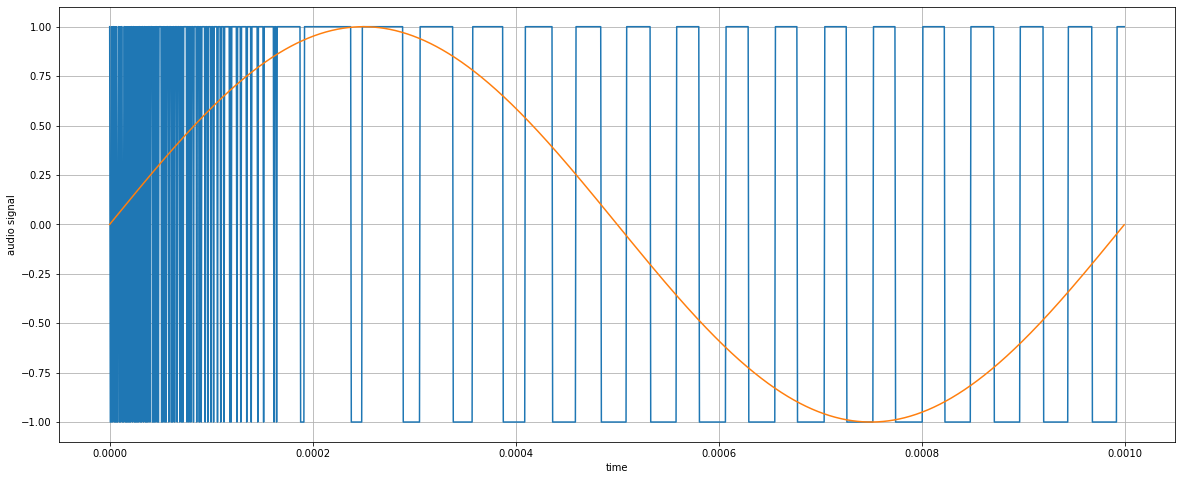

In [3]:
# let's creat an audio signal: sigma-delta module requires an input normalized to [-1,1]
freq = 1000
num_periods = 1
duration = num_periods/freq
fs = PDM_SAMPLING_RATE      # we could use other sampling rates for the input audio signal
                            # but ultimately sigma-delta module resamples it to create a very high-rate signal as input
time_vec = np.arange(0, duration, step=1/fs)

audio = np.sin(2*np.pi*freq* time_vec)

bit_stream, _, _ = mic(audio)

# - We can also specify an alternative sampling rate as so:
bit_stream, _, _ = mic((audio, fs))

# plot the audio and its PDM bit-stream
plt.figure(figsize=(20,8))
plt.plot(time_vec, bit_stream)
plt.plot(time_vec, audio)
plt.grid(True)
plt.xlabel("time")
plt.ylabel("audio signal")
plt.show()

It is seen that the output PDM bit-stream is a $\{+1, -1\}$ valued signal where the frequency of 1 increase proportionally to the amplitude
of the incoming audio, thus, pulse density modulation.

Now lets play a little bit and reduce the amplitude of the signal. We can check that as the amplitude goes down +1 and -1 start to happen with almost the same frequency.
So we see a lot of switching between +1 and -1 whereas in the high amplitude case there are consecutive blocks of +1 or -1.

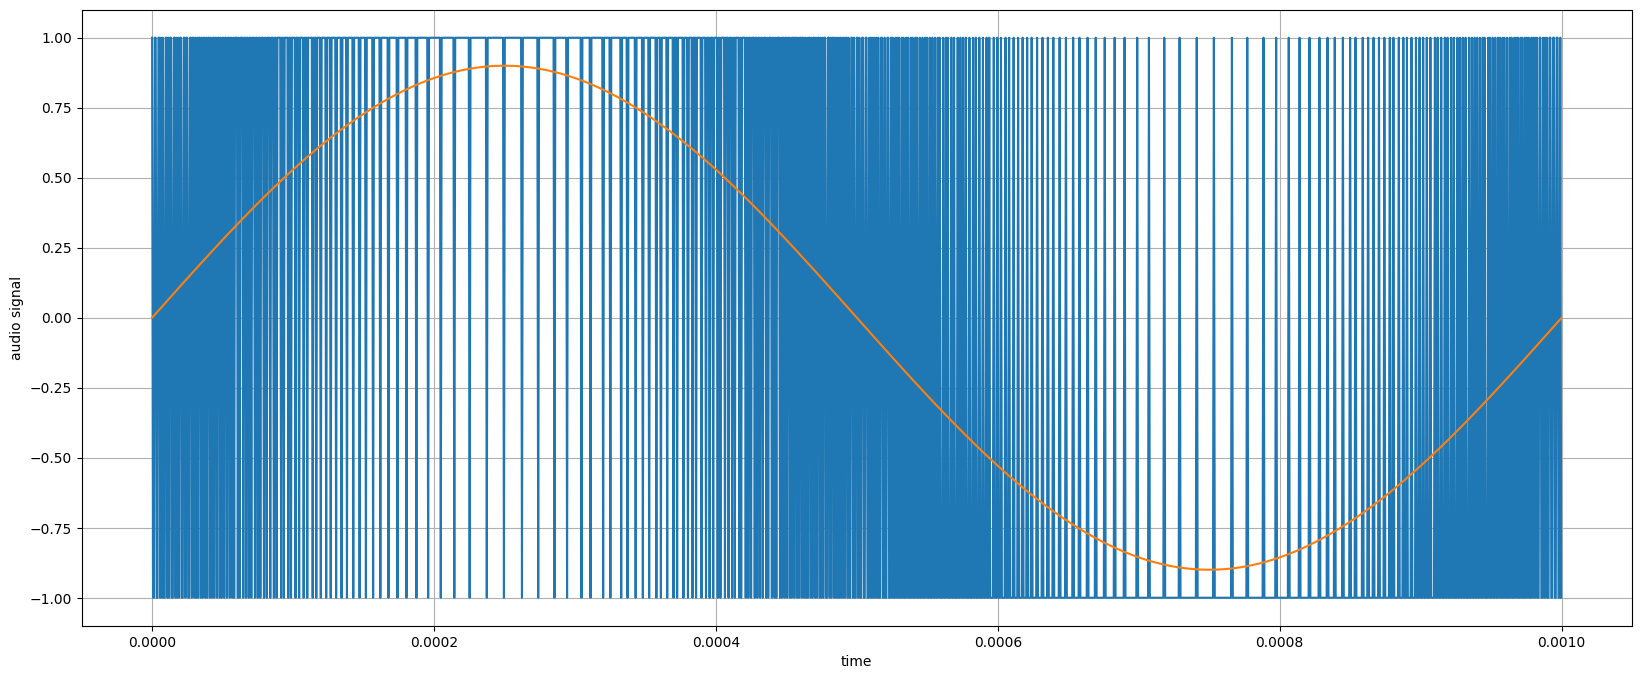

In [ ]:
# let's reduce the amplitude
amplitude = 0.9
audio = amplitude * np.sin(2*np.pi*freq* time_vec)

bit_stream = mic(audio)

# plot the audio and its PDM bit-stream
plt.figure(figsize=(20,8))
plt.plot(time_vec, bit_stream)
plt.plot(time_vec, audio)
plt.grid(True)
plt.xlabel("time")
plt.ylabel("audio signal")
plt.show()

## Module 1-2: Low-pass filtering & Decimation
As we mentioned, the next block we need to make a signal quantization as in conventional ADCs is a low-pass filter that takes the high-rate bit-stream produced by the PDM microphone (via sigma-delta modulation)
and tries to reproduce a faithful quantized replica of the input audio signal upto finite number of bits.

Here, fortunately, we have a good flexibility:
- in conventional ADC's the complexity (power consimpution, chip area, signal-to-noise ratio, ect.) grows with the number of bits used for quantizing the signal.
- if inspect the way PDM microphone  + low-pass filtering works, we can implement the low-pass filter with as many bits as possible since it is implemented in digital logic and increasing the number of bits is not that problematic as in conventional ADCs. However, there is a limit to this and beyond some number of quantization bits for the filter and its output, the improvement in performance simply saturates.

We did experiments with various filters, number of quantization bits for quantzing their taps/parameters and decided to use FIR (finite impulse response) filters for the following reasons:
- although IIR filters are also a good option and have even a sharper frequency response, they are not the best option for PDM bit-streams because
  - IIR filters are unable to use the nice feature of the PDM output, which is a binary-valued signal. 
  - IIR filters are not that efficient when their computed output is decimated since they need to compute all the samples of the signal and there is no easy way to avoid this since in IIR filters compuation is based on the memory elements and these memory elements require computing all the samples of the signal. In simple terms, it is not possible to design an IIR filter whose output is a decimated version of the output of another IIR filter.
  - for implementing IIR filters, one needs to use state-space method and use quantized versions of the filter taps. This quantization is very bad for low-frequency filters, which is the case in the audio recovery problem we target in this project.
  - IIR filters require multiplication, which consumes much more power than addition (as we will show to be the case for FIR filters with the PDM input).
  - IIR filters have a higher potential of overflow and underflow and they need larger number of bits for their implementation to gurad againts numerical instabilities. In contrast, FIR filters are always stable since due to their feedforward (no feedback) structure.  

- FIR filters are in general inefficient compared with IIR ones since they need a lot of multiplications for their implementtaion. Fortunately, this is not the case for PDM output since it is a binary-valued signal for which multplication with filter taps can be easily implemented by addition.
- In the special case of low-pass filtering followed by decimation we have in Xylo design, FIR filters can be computed with a mich higher efficiency by applying a technique known as polyphase implementation, which allows to compute only those output samples of the low-pass filter that are kept after decimation (and are treated as quantized audio samples in the next stages). 
- Unfortunately FIR filters do not have as sharp frequency response as IIR filters. However, they have a quite nice feature that they can be designed to have a linear phase response so that all the frequency components of the signal are shifted by the same time delay, thus, no time delay distortion, which is a very nice feature to have in Xylo chip where we extract time-frequnecy features of the signal as spike features.

Based on these reasonings, we decided to use FIR filters for our design. 

As we mentioned before, FIR filters are not that sharp in the frequency domain and may create some distortion in the pass-band and weaker attenuation in the stop-band. 

We made sure that the attenuation in the stop-band is sufficiently larger to avoid the high-frequency noise in PDM output (due to noise shaping)  leaking to the pass-band. 

Also, furtunately in our case, the distortion in the pass-band is not so problematic since the resulting signal is forwarded to the Xylo filterbank where it is further filtered and decomposed into finer frequency bands. So a slight attenuation in one part of the pass-band simply translates to a  reduction in the spike rate obtained from the filter in Xylo front-end corresponding to that frequency, which can be easily compensated by the following divisive normalizatoion module or even in SNN if needed.


We would like to refer to the following documentation for further details on design, simulation, and parameter selection:

https://spinystellate.office.synsense.ai/saeid.haghighatshoar/pdm-microphone-analysis


Let's paly with the low-pass filter and see how it is able to recover the original audio.

In [ ]:
# build a low-pass filter module: note that we use polyphase implementation technique known in multi-rate signal processing to reduce the number of computation, thus, power consumption.
from rockpool.devices.xylo.xylo_a3 import PolyPhaseFIR_DecimationFilter


lp = PolyPhaseFIR_DecimationFilter()

# let's check the parameters of the filter
print(lp._info())

Polyphase FIR filter:
PDM sampling rate: 1562500.0
filter length: 512
filter cutoff frequency: 20000
filter transition width: 4000.0
decimation factor: 32
number of quantization bits for filter taps: 16
number of bits at the output of the filter before final bit-truncation: 21
number of bits at the final output: 14



/Users/haghighat/SynSense Dropbox/Saeid Haghighatshoar/Projects/rockpool/rockpool/devices/xylo/xylo_a3/xylo_a3_sim/pdm_adc.py:525: UserWarning: filter cutoff-width was unset in the implementation to futher lower-down the tail response!
  warnings.warn(


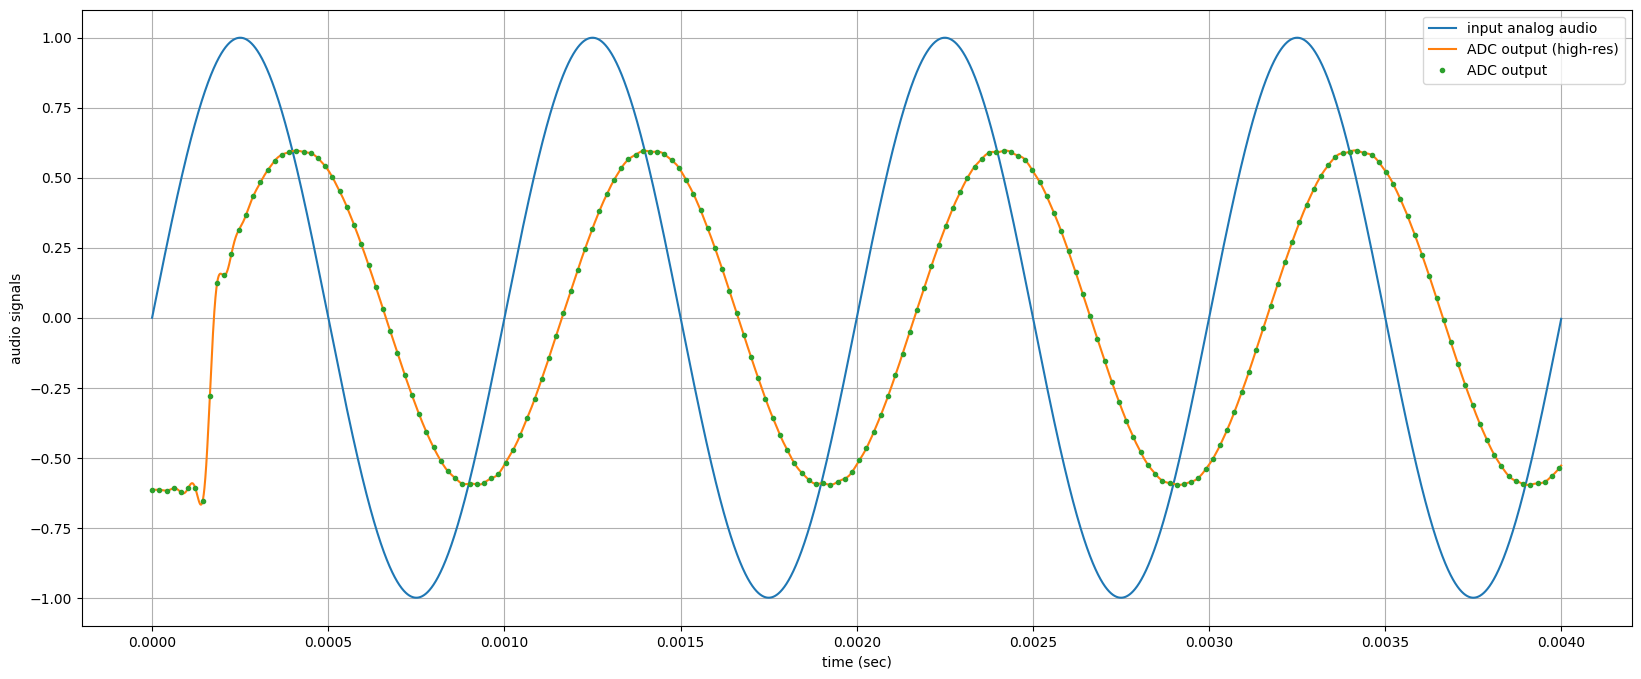

In [ ]:
# - now lets process the pdm signal with the low-pass filter: we have the option to see the high-resolution version before decimation

# let's creat an audio signal: sigma-delta module requires an input normalized to [-1,1]
freq = 1000
num_periods = 4
duration = num_periods/freq
fs = PDM_SAMPLING_RATE      # we could use other sampling rates for the input audio signal
                            # but ultimately sigma-delta module resamples it to create a ver high-rate signal as input
time_vec = np.arange(0, duration, step=1/fs)

audio = np.sin(2*np.pi*freq* time_vec)

bit_stream, _, _ = mic(audio)

# estimated audio: decimated version and high-res version before decimation
audio_est, _, _ = lp(bit_stream)

# - For testing, obtain a non-decimated LP version
audio_est_high_res = lp._evolve_no_decimation(bit_stream)

# since the signals are quantized (here to 14 bits), we need to apply some amplitude normalization for comparsion
audio_est = audio_est/2**(lp.num_bits_output-1)
audio_est_high_res = audio_est_high_res/2**(lp.num_bits_output-1)


# plot the results
plt.figure(figsize=(20,8))

# plt.plot(time_vec, audio)
# plt.plot(time_vec, audio_est_high_res)

# some time adjustment is needed since the number of samples changes after filtering
plt.plot(time_vec, audio)
plt.plot(time_vec, audio_est_high_res[:len(time_vec)])
plt.plot(time_vec[::lp.decimation_factor], audio_est[:len(time_vec[::lp.decimation_factor])], '.')

plt.xlabel("time (sec)")
plt.ylabel("audio signals")
plt.grid(True)
plt.legend(['input analog audio', 'ADC output (high-res)', 'ADC output'])
plt.grid(True)

plt.show()


**Remark**
From the results it is seen that the amplitude of the ADC output after normalizatiuon is slightly less than the amplitude of the signal. This simply means that
The input signal is not able to fill the whole dynamic range provided by the quantization bits. 
This is quivalent to saying that almost (less than) 1 bit of ADC is wasted. So indeed ADC has 13 bits, which is still enough for audi applications.
For example, the target bit in SAR ADC originally planned for Xylo-A3 was only 10 bits, so we are still in a good shape.

The main reason we had to design like this was that there are some worst-case audio signals that may have the potential to fill the whole dynamic range of the quantized bits.
So this 1-bit loss is the cost we pay for handling those worst-case audio signals.


**Remark.** 
Another reason for losing the dynamic range especially in high-freq signals is due to the non-flat response of the filter in frequency. 
This implies that high-freq signals are attenuated, thus, lose quantization bits.


As a final sanity check, let's repeat the simulations with two other frequencies: 100 and 10_000 Hz and see how the ADC output looks like in those cases.



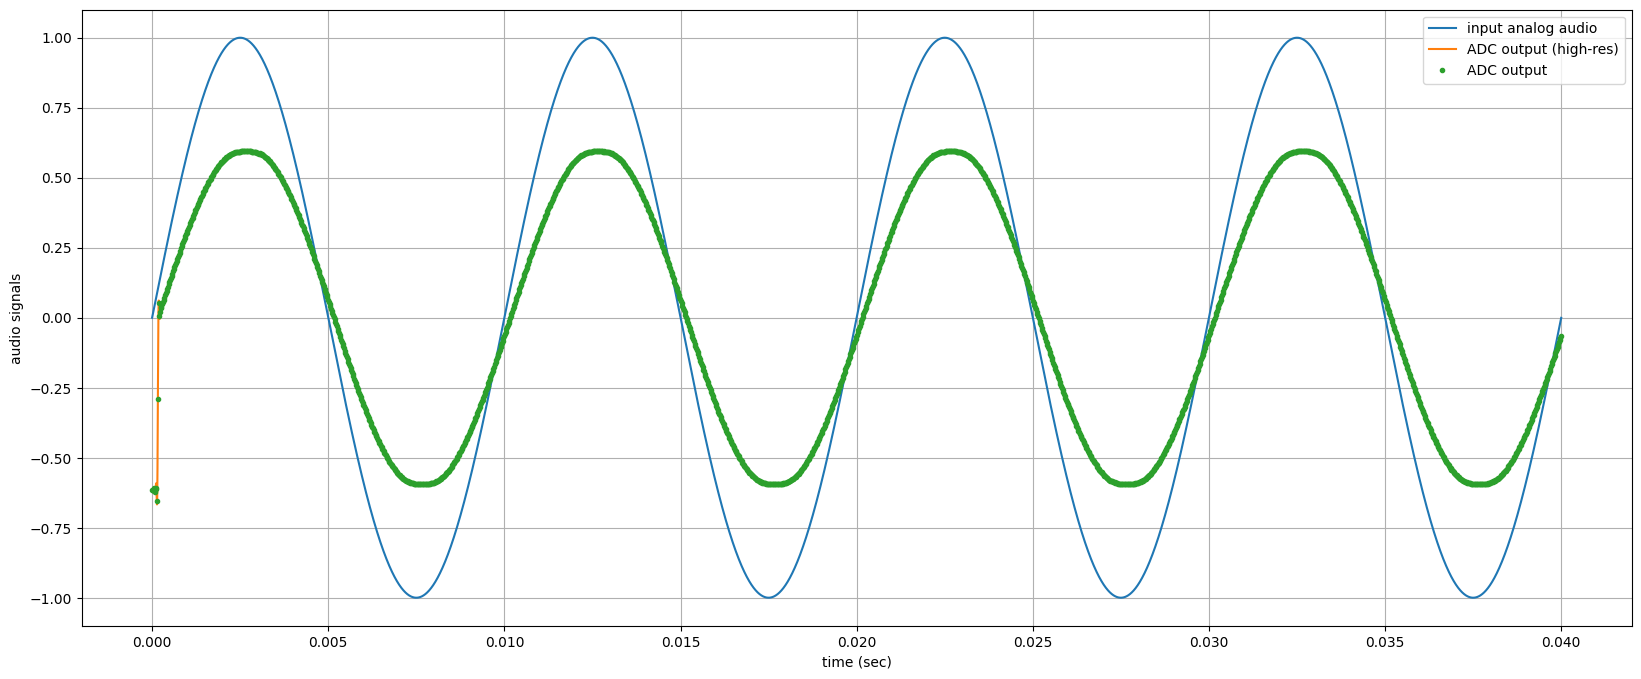

In [ ]:
#######################################################
# - low-freq signal
#######################################################

# - now lets process the pdm signal with the low-pass filter: we have the option to see the high-resolution version before decimation

# let's creat an audio signal: sigma-delta module requires an input normalized to [-1,1]
freq = 100
num_periods = 4
duration = num_periods/freq
fs = PDM_SAMPLING_RATE      # we could use other sampling rates for the input audio signal
                            # but ultimately sigma-delta module resamples it to create a ver high-rate signal as input
time_vec = np.arange(0, duration, step=1/fs)

audio = np.sin(2*np.pi*freq* time_vec)

bit_stream, _, _ = mic(audio)

# estimated audio: decimated version and high-res version before decimation
audio_est, _, _ = lp(bit_stream)

audio_est_high_res = lp._evolve_no_decimation(bit_stream)

# since the signals are quantized (here to 14 bits), we need to apply some amplitude normalization for comparsion
audio_est = audio_est/2**(lp.num_bits_output-1)
audio_est_high_res = audio_est_high_res/2**(lp.num_bits_output-1)


# plot the results
plt.figure(figsize=(20,8))

# plt.plot(time_vec, audio)
# plt.plot(time_vec, audio_est_high_res)

# some time adjustment is needed since the number of samples changes after filtering
plt.plot(time_vec, audio)
plt.plot(time_vec, audio_est_high_res[:len(time_vec)])
plt.plot(time_vec[::lp.decimation_factor], audio_est[:len(time_vec[::lp.decimation_factor])], '.')

plt.xlabel("time (sec)")
plt.ylabel("audio signals")
plt.grid(True)
plt.legend(['input analog audio', 'ADC output (high-res)', 'ADC output'])
plt.grid(True)

plt.show()


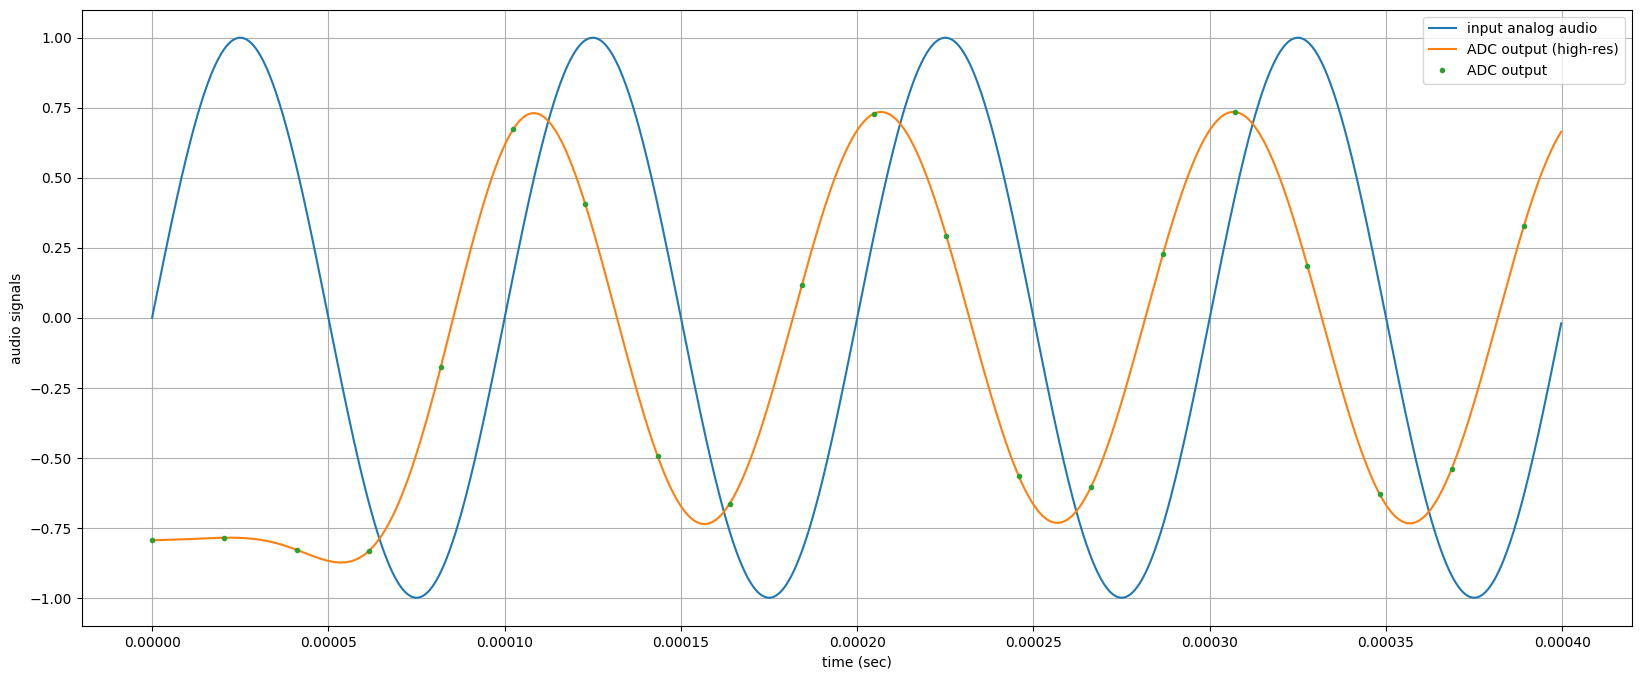

In [ ]:
#######################################################
# - high-freq signal
#######################################################

# - now lets process the pdm signal with the low-pass filter: we have the option to see the high-resolution version before decimation

# let's creat an audio signal: sigma-delta module requires an input normalized to [-1,1]
freq = 10_000
num_periods = 4
duration = num_periods/freq
fs = PDM_SAMPLING_RATE      # we could use other sampling rates for the input audio signal
                            # but ultimately sigma-delta module resamples it to create a ver high-rate signal as input
time_vec = np.arange(0, duration, step=1/fs)

audio = np.sin(2*np.pi*freq* time_vec)

bit_stream, _, _ = mic(audio)

# estimated audio: decimated version and high-res version before decimation
audio_est, _, _ = lp(bit_stream)

audio_est_high_res = lp._evolve_no_decimation(bit_stream)

# since the signals are quantized (here to 14 bits), we need to apply some amplitude normalization for comparsion
audio_est = audio_est/2**(lp.num_bits_output-1)
audio_est_high_res = audio_est_high_res/2**(lp.num_bits_output-1)


# plot the results
plt.figure(figsize=(20,8))

# plt.plot(time_vec, audio)
# plt.plot(time_vec, audio_est_high_res)

# some time adjustment is needed since the number of samples changes after filtering
plt.plot(time_vec, audio)
plt.plot(time_vec, audio_est_high_res[:len(time_vec)])
plt.plot(time_vec[::lp.decimation_factor], audio_est[:len(time_vec[::lp.decimation_factor])], '.')

plt.xlabel("time (sec)")
plt.ylabel("audio signals")
plt.grid(True)
plt.legend(['input analog audio', 'ADC output (high-res)', 'ADC output'])
plt.grid(True)

plt.show()


**Remark.**
By comparing the simulation results for signals with frequencies $100 \ll 1000 \ll 10000$ Hz, we can see that
- even at lower frequencies, the nromalized amplitude of the signal does not go beyond $\sim 0.77$, which is due to loss in dynamic range needed for handling worst-case audio signals.
- at higher frequencies the amplitude goes further down as a result of non-flat frequency response of the low-pass filter. This incurs additional loss in dynamic range as we axplained.

--- 

## Module 2: Filterbank

The key feature extraction module in Xylo-A3 is the collectuion of Mel-filterbanks, which compute the time-frequency transform of the input audio signal.

One nice feature of Xylo-A3 is that all the filters have been implemented in the digital domain. Therefore, they are not have the mismatch effect we had in 
the analog filters impelemented in Xylo-A2.

We refer to the following Dropbox document for complete details of design, quantization, implementation, and worst-case analysis of the filters:

https://paper.dropbox.com/doc/Feasibility-study-for-AFE-with-digital-intensive-approach-b07tQKnwpfDFYrZ5E8seQ


We uses order-1 Butterworth filters which conver the range of 100 up to around 18 KHz audio spectrum. 
Note that in Xylo-A2 filters were order-2 filters. We decided to replace them by order-1 since accoridng to our analysis filters should not have a selectrivity $Q$ larger than 5-6.
Otherwise the filterbank will have some notches in the frequency and may badly eliminate features at those frequencies.
This is mainly due to the fact that the filters are logarithmically spaced, thus, they are alreday undersampling the frequency. And with larger $Q$, they may indeed impose a notch in some 
target audio frequencies.

We applied a very efficient quantization method in order to maximize the dynamic range of teh filters while avoiding any over- and under-flow.
We checked this carefully both theoretically and also numerically. We refer to the documentation for further details.

Ultimately filters were implemented as AR (auto-regressive or feedback) part followed by MA (moving average of feedforward) part.
We quantized the filters as the follwing block-diagram format.

The python implementation is also based on the block-diagram representation.

**AR Part.**

![Fig.6. Block-diagram of AR part of the filter.](https://paper-attachments.dropbox.com/s_00FD2B1B8C81FE173CAE1A9B43B1B9CFD30AC2D480E650171962E43D6FA1C599_1646429910807_block_diagram_ar2.png)


**MA Part.**

![Fig.7. Block-diagram of MA part of the filter.](https://paper-attachments.dropbox.com/s_00FD2B1B8C81FE173CAE1A9B43B1B9CFD30AC2D480E650171962E43D6FA1C599_1647028610929_MA_block_2.png)




**Remark.**
To have a high speed, filterbank module is implemented in Jax. So it becomes faster after the first run.

### Example 1: A chirp signal as input
Now let's play with the filterbank module.
As the first example, let's use a chirp signal to see what would be the output.

To have some fun:
- we use the filterbank output to estimate the time at which each filter atains its maximum signal amplitude.
- since chirp sweeps the frequency linearly, we use this time-of-peak to estimate the ratio between consecutive central frequencies. 
- we comapre this empirical value with the design value which is around $1.41$.



Jax version was found! Filterbank will be computed using jax speedup!



 ++++++++++++++++++++++++++++++++++++++ jax version of filters ++++++++++++++++++++++++++++++++++++++ 

dimension of the input signal:  244140
compile time:  0.8932878971099854
run time:  0.18313193321228027 

relative scaling of designed filters => empirical via LSQ: 1.4694659921458493, design: 1.4142135623730951


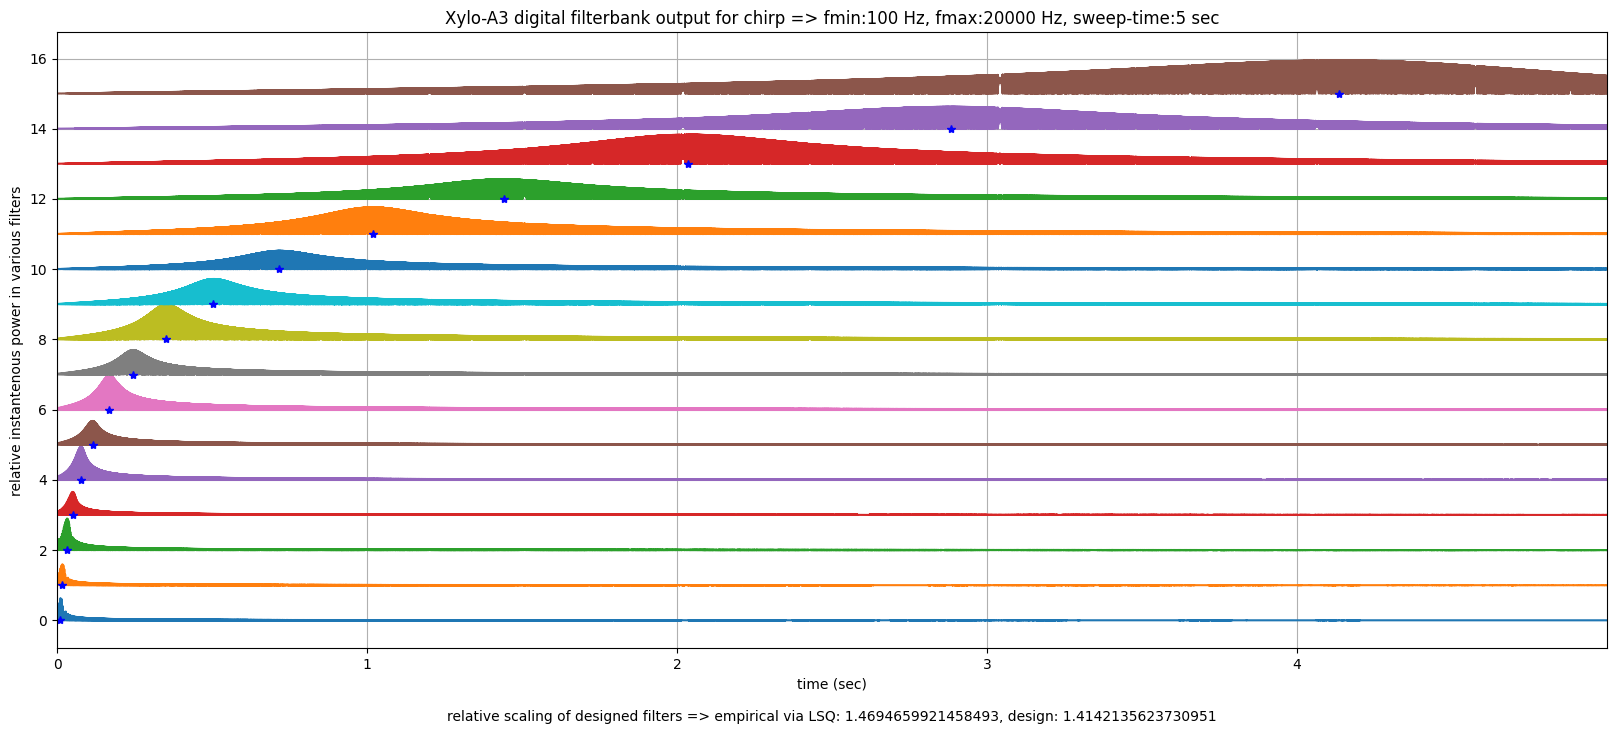

In [ ]:
# required packages

# block-diagram version of the filters
from rockpool.devices.xylo.xylo_a3 import ChipButterworth

# import the ADC module to use the default parameters used in Xylo-A3
from rockpool.devices.xylo.xylo_a3 import PDM_ADC

from rockpool.timeseries import TSContinuous

import time


def test_filterbank_chirp():
    """ this is a simple test of filters for a chirp signal. """

    # just to extract the default audio sampling rate
    pdm_adc = PDM_ADC()
    
    # filterbank
    fb = ChipButterworth()
    
    #===========================================================================
    #                            produce a chirp signal
    #===========================================================================
    fmin = 100
    fmax = 20_000
    sample_rate = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    duration = 5
    
    num_samples = int(duration * sample_rate)
    dt = duration/num_samples
    
    # instantenous frequency
    f_inst = np.linspace(fmin, fmax, num_samples)
    phi_inst = 2 * np.pi * np.cumsum(f_inst) * dt
    
    sig_in = np.sin(phi_inst)


    # quantize the signal: additional 4 bits because HW team decided to use 14 bit PDM (compare it with the iriginal 10 bit SAR ADC)
    Q = fb.bd_list[0].B_in + 4
    EPS = 0.00001
    sig_in = (sig_in/(np.max(np.abs(sig_in)) * (1+EPS)) * 2**(Q-1) ).astype(np.int64)
    

    
    #===========================================================================
    #                            Jax version
    #===========================================================================

    start = time.time()

    sig_out_jax, _, recording_jax = fb(
        sig_in,
        record=True,
        scale_out=False,
    )

    duration_jax_compile = time.time() - start


    start = time.time()

    sig_out_jax, _, recording_jax = fb(
        sig_in,
        record=True,
        scale_out=False,
    )

    duration_jax = time.time() - start

    print("\n", " jax version of filters ".center(100, "+"), "\n")
    print("dimension of the input signal: ", len(sig_in))
    print("compile time: ", duration_jax_compile)
    print("run time: ", duration_jax, "\n")

   
    # normalize the signal for better viuslaization
    sig_out_jax = np.abs(sig_out_jax/np.max(np.abs(sig_out_jax)))

    # find the time at which each channel reaches its maximum amplitude
    # apply LSQ to find the scaling parameter
    T_max = np.argmax(sig_out_jax, axis=0)*dt
    filter_idx = np.arange(fb.numF)

    A = np.asarray([[1]*len(T_max), np.cumsum([1]*len(T_max))]).T
    y = np.log(T_max)
    params = np.linalg.lstsq(A, y, rcond=None)[0]

    log_alpha = params[1]
    exp_filter_scaling_param = np.exp(log_alpha)
    print(f"relative scaling of designed filters => empirical via LSQ: {exp_filter_scaling_param}, design: {np.sqrt(2)}")
    

    plt.figure(figsize=(20,8))
    TSContinuous.from_clocked(sig_out_jax, dt=1/sample_rate).plot(stagger=1)
    plt.grid(True)
    plt.xlabel(
        "time (sec)\n\n"+\
        f"relative scaling of designed filters => empirical via LSQ: {exp_filter_scaling_param}, design: {np.sqrt(2)}"
    )
    plt.ylabel("relative instantenous power in various filters")
    plt.title(f"Xylo-A3 digital filterbank output for chirp => fmin:{fmin} Hz, fmax:{fmax} Hz, sweep-time:{duration} sec")

    plt.plot(T_max, filter_idx, 'b*')
    
    plt.show()


# call the function
test_filterbank_chirp()

### Example 2: Empirical evaluation of the frequency response of the filters
The implemented digital filters have quite complicated quantization behavior and we need to make sure that these quantization errors are negligible 
so that they do not incur significant loss in signal-to-noise-ration(SNR).

Here as a sanity check we compute the frequency responses of the filters via direct simulation and verify that they  indeed match
the Mel-filterbank.

To produce the frequency response:
- we produce sinusoid signals with various frequencies.
- we pass the signal through tehe filters and remove the transient parts of the filter to have the steady-state filter output, which would be a sinusoid.
- we comapte the ratio between the amplitude of the input and output sinusoid.

Let's see what we get.

In [ ]:

# required packages
from tqdm import tqdm
from rockpool.devices.xylo.xylo_a3 import PDM_ADC
from rockpool.devices.xylo.xylo_a3 import ChipButterworth
import numpy as np

def test_freq_response():
    """this functions validates the frequency responses of the filters via numerical simulations."""
    # just to extract the default audio sampling rate
    pdm_adc = PDM_ADC()
    
    # filterbank
    fb = ChipButterworth()
    
    # range of frequencies covered
    fmin = 100
    fmax = 20_000
    sample_rate = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    duration = 1        # in seconds: this is large enough to guarrantee that all the filters reach their steady state
    time_vec = np.arange(0,duration, step=1/sample_rate)

    # list of frequencies to probe
    num_freq = 1000
    freq_vec = 10**np.linspace(np.log10(fmin), np.log10(fmax), num_freq)


    freq_response = []
    for freq in tqdm(freq_vec):
        # produce a sinusoid signal
        sig_in = np.sin(2*np.pi*freq*time_vec)

        # quantize the sinal
        B_in = fb.bd_list[0].B_in + 4
        EPS = 0.00001
        sig_in = (sig_in/(np.max(np.abs(sig_in)) * (1+EPS)) * 2**(B_in-1) ).astype(np.int64)

        # compute the frequency response
        sig_out, _, _ = fb(
            sig_in,
            record=False,
            scale_out=True,
        )

        freq_res = np.mean(sig_out**2, axis=0)/np.mean(sig_in**2)

        freq_response.append(freq_res)

    freq_response = np.asarray(freq_response)
    freq_response = freq_response/np.max(freq_response)

    # convert into dB
    freq_response_dB = 10*np.log10(freq_response)

    # plot the results
    plt.figure(figsize=(16,10))
    plt.semilogx(freq_vec, freq_response_dB)
    plt.xlabel("freq (Hz)")
    plt.ylabel("freq response [dB]")
    plt.grid(True)
    plt.title("empirical frequency response of Xylo-A3 filterbank")
    plt.ylim([-10,1])

    plt.show()

# call the function
test_freq_response()

 89%|████████▉ | 889/1000 [01:09<00:08, 13.07it/s]

**Remark.**
From the frequency response, we can see that the two low-frequency filters are a little bit imprecise: 
- the center frequency of the lowest filter is around 110 Hz rather than 100.
- the center frequency of the second filter is around 130 Hz, so slightly lower than the target value 1.41 x 100 = 141 Hz.

This is due to the fact that the low-frequency filters have a very bad dynamic range in their filter coefficients and with the values we have selected (around 16 bits for quantization)
their poles variy sligtly away from the desired value. However, this should be tolerable in our case.

**Remark.**
Another observation is that the 3dB frequency of each filter coincides with teh 3dB frequency of its neghbors. This was to make sure that the filters have almost 
flat power response in frequency domain, ths, no notch. Mathematically speaking:
$$\sum_{k=1}^{16} |H_k(f)|^ 2 \approx 1, \ \ f \in [100, \sim 18000]$$
where $H_k(f)$ denotes the frequency response of the $k$-th filter at frequency $f$.
This was the main reason we did not use order-2 Butterworth filters since we could not have more selective filters.


### Example 3: Worst-case analysis of the filters (a little bit boring)
The chip resgisters assigned to saving digital filters states should be large enough to avoid any under- and over-flow. To assure this, we need to do worst-case analysis on the filters.
More specifically we need to find the worst input at each filter that yields the largest amplitude in filter output.

In our design, filters have to parts: AR and MA part. It is not difficult to see that we need to be more careful about AR part due to the feedback loop.
Also, MA filter takes the output of AR filter $w[n]$ and computes $w[n]-w[n-2]$. Since it consists in taking the difference of consecutive samples, it is unlikely to yield a very large amplitude.

For the AR part, we use the following theorem to build the worst case input to each filter.

**Theorem.** Let $h[n]$ be the impulse response of a filter. Then, the worst-case input signal for the filter of amplitude 1 is given by $x[n] = sign(h[-n])$ where $sign$ denotes the conventional
sign function and where $h[-n]$ denotes a time-flipped version of the impulse response. Also, the worst-case amplitude at the output is given by $\sum_{n}|h[n]|$.

Uisng this theorem, we build the worst-case signal for each filter and apply worst-case analysis. 
In the filter design (see the documentation in Dropbox report), we have sepcified the parameter `B_worst_case` as the additional number of bits compared with the input bitsize
that is needed to be assigned to each filter to avoid any over- and under-flow in such worst case scenarios. 

We will compare these values with the required values we obtain from the simulations.
The simulation results show that the selected number of additional bits is enough.

/home/saeid/Projects/Projects/xylo-a3-simulator/xylo_a3_sim/pdm_adc.py:525: UserWarning: filter cutoff-width was unset in the implementation to futher lower-down the tail response!
  warnings.warn(


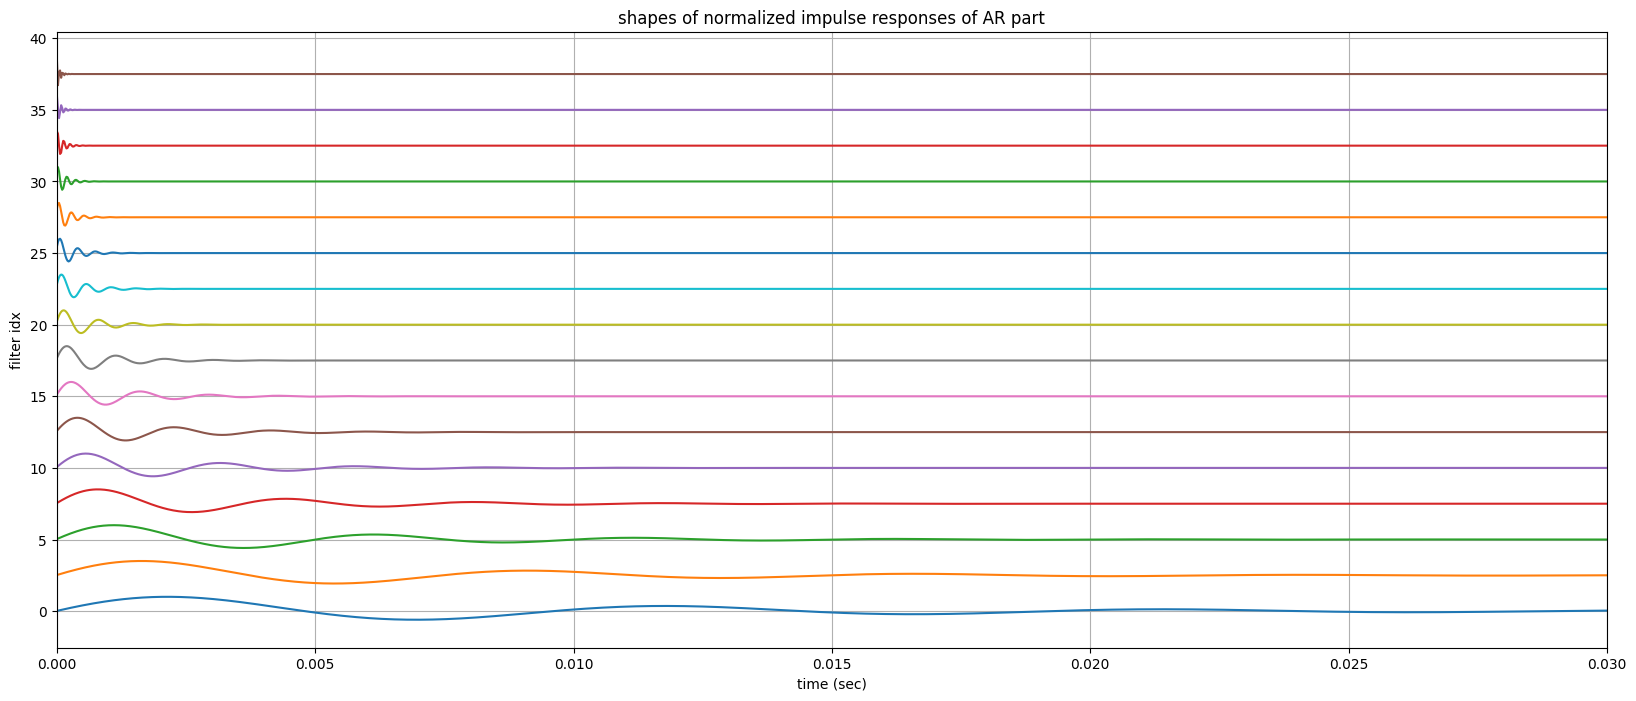

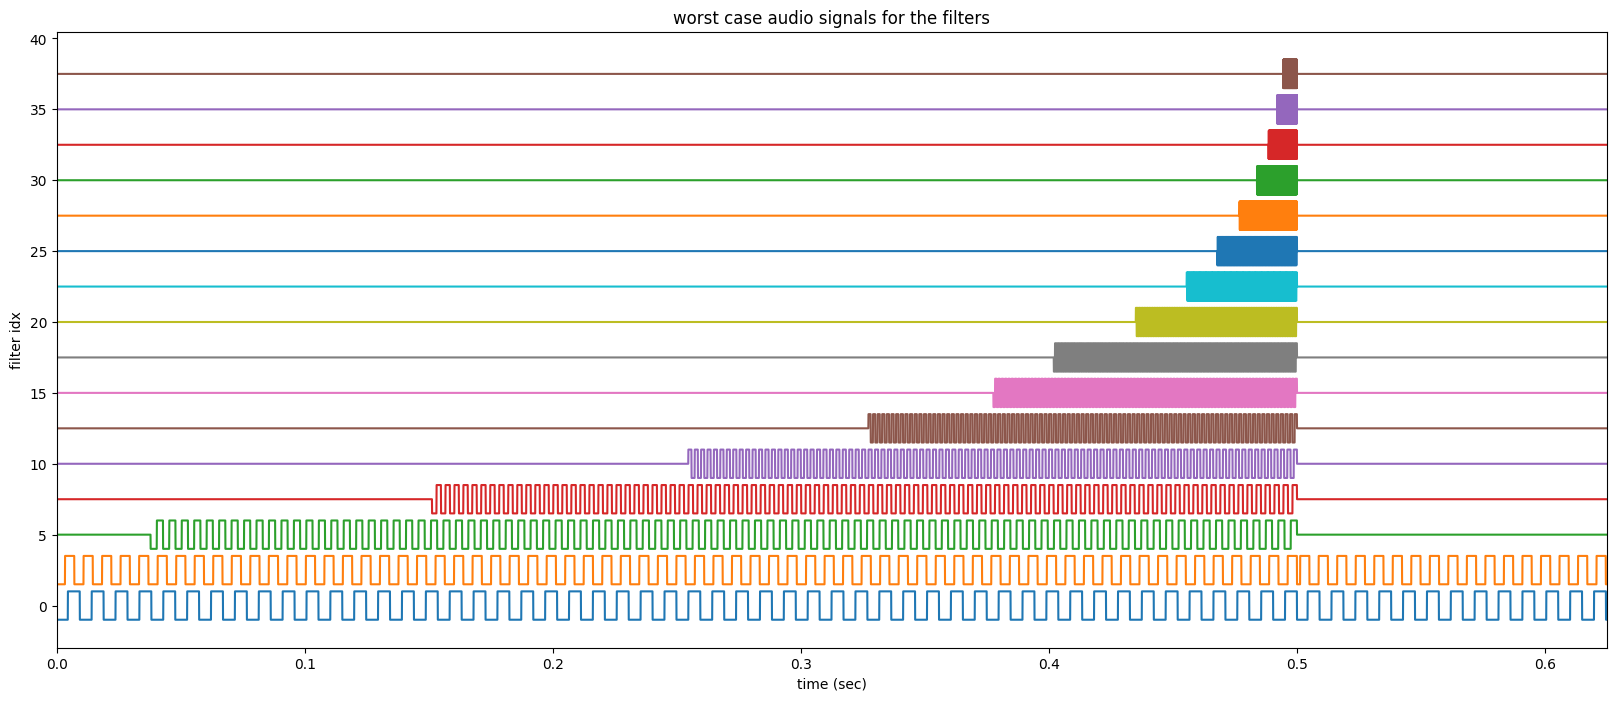

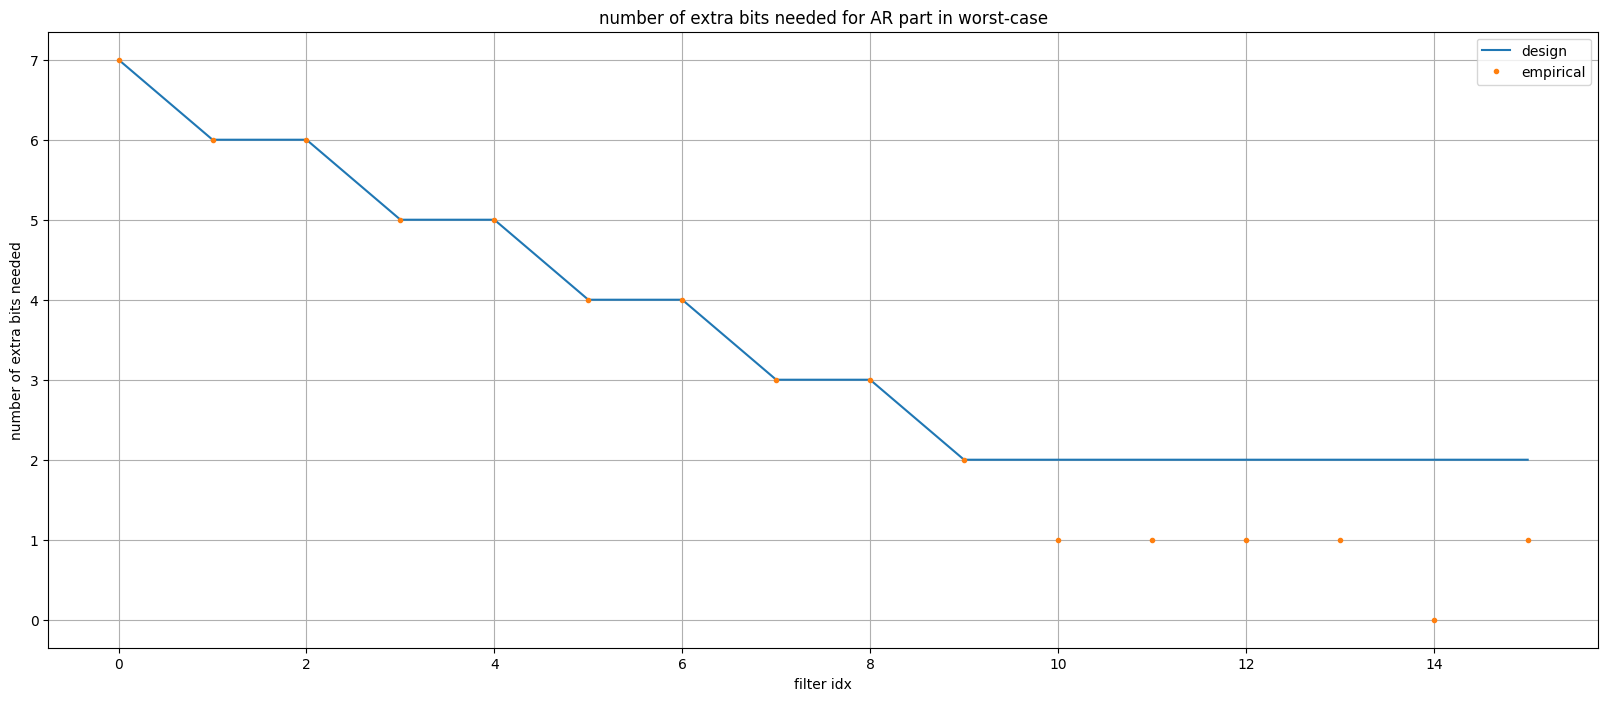

In [ ]:
# required packages
import numpy as np
from rockpool.devices.xylo.xylo_a3 import PDM_ADC
from rockpool.devices.xylo.xylo_a3 import ChipButterworth
import matplotlib.pyplot as plt
from rockpool.timeseries import TSContinuous


def test_filterbank_jax_worst_case():
    """ this function does the worst-case analysis for the filterbank using the jax version."""
    # just to extract the default audio sampling rate
    pdm_adc = PDM_ADC()
    
    # filterbank
    fb = ChipButterworth()
    
    # sample rate
    sample_rate = pdm_adc[0].fs/pdm_adc[0].sdm_OSR

    # number of quantization bits: additional 4 bits since hardware team decided to use 14 bits PDM ADC comapred with the originally decided 10 bit SAR ADC
    Q = fb.bd_list[0].B_in + 4
    
    # - compute the impulse response of AR part of the filters
    # to compute this we need to store the states of the filter during simulation
    duration = 1
    num_samples = int(duration * sample_rate)
    impulse = np.zeros(num_samples)
    impulse[0] = 1
    
    # quantize the input signal
    EPS = 0.00001
    impulse = (impulse * (2**(Q-1))/(1+EPS)).astype(np.int64)
    
    # compute the output of the filterbank
    sig_out, _, recording = fb(
        impulse,
        record=True,
        scale_out=False,
        python_version=False,
    )
    
    # compute the output of AR filters from the computed states: this corresponds to the impulse responses of the filters
    # recordings are  T (time) x 16 (num filter) x 3 (registers used as state)
    AR_registers = recording["filter_AR_state"][:,:,0]

    # plot the impulse responses of the filters
    imp_res_normalized = AR_registers/np.max(AR_registers, axis=0).reshape(1,-1)
    
    plt.figure(figsize=(20,8))
    TSContinuous.from_clocked(imp_res_normalized, dt=1/sample_rate).plot(stagger = 2.5)
    plt.xlabel("time (sec)")
    plt.ylabel("filter idx")
    plt.title("shapes of normalized impulse responses of AR part")
    plt.xlim([0, 0.03])
    plt.grid(True)


    # plot the worst case signals for each filter
    normalized_worst_case_signals = np.roll(np.sign(AR_registers[(5*len(AR_registers)//8)::-1,:]), len(AR_registers)//2, axis=0)

    plt.figure(figsize=(20,8))
    TSContinuous.from_clocked(normalized_worst_case_signals, dt=1/sample_rate).plot(stagger = 2.5)
    plt.xlabel("time (sec)")
    plt.ylabel("filter idx")

    plt.title("worst case audio signals for the filters")
    
    # how much output of AR filter is larger compared with the input signal
    worst_case_AR_amplitude_amplification = []
    
    for filt_idx, ar_response in enumerate(AR_registers.T):
        # requantize the output
        
        worst_case_in = ( np.sign(ar_response[::-1])/(1+EPS) * 2**(Q-1) ).astype(np.int64)
        
        # compute the output of the filters
        sig_out, _, recording = fb(
            worst_case_in,
            record=True,
            scale_out=True,
            python_version=False,
        )
        
        # compute the corresponding AR output: from the T (time) x 16 (num filter) x 3 (registers used as state) 
        worst_case_out = recording["filter_AR_state"][:,filt_idx,0]
        
        # compute the amplification factor
        worst_case_AR_amplitude_amplification.append(np.max(np.abs(worst_case_out))/np.max(np.abs(worst_case_in)))
        
    # how many extra bits are needed to avoid any over- and under-flow in the filters
    worst_case_extra_bits = np.ceil(np.log2(worst_case_AR_amplitude_amplification)).astype(np.int64)

    # remove the effect of B_wf bits added to avoid dead zone in the filter (they are already taken into account)
    worst_case_extra_bits -= np.asarray([bd.B_wf for bd in fb.bd_list])
    
    # what is the designed extra bits
    designed_worst_case_extra_bits = np.asarray([bd.B_worst_case for bd in fb.bd_list])
    
    
    plt.figure(figsize=(20,8))
    plt.plot(designed_worst_case_extra_bits)
    plt.plot(worst_case_extra_bits, ".")
    plt.legend(["design", "empirical"])
    plt.grid(True)
    plt.xlabel("filter idx")
    plt.ylabel("number of extra bits needed")

    plt.title("number of extra bits needed for AR part in worst-case")
    
    plt.show()    

# call the function
test_filterbank_jax_worst_case()

As we can see from the plots, the worst-case signal for the filters are almost $\pm 1$-valued signals. 
It would be nice if we can also double-check this by more reasonable signals, i.e., sinusoid audio signals in the bandwidth of the filter.
A nice candidate is to use the same chirp signal we use in the previous part.

One can see that the chirp signal is also very close to the worst case signal since it can be very close to the responance frequency of each filter during sweep time.
However, it  still requires less additional bits than the worst-case $\pm 1$-values pulses we investigated before.

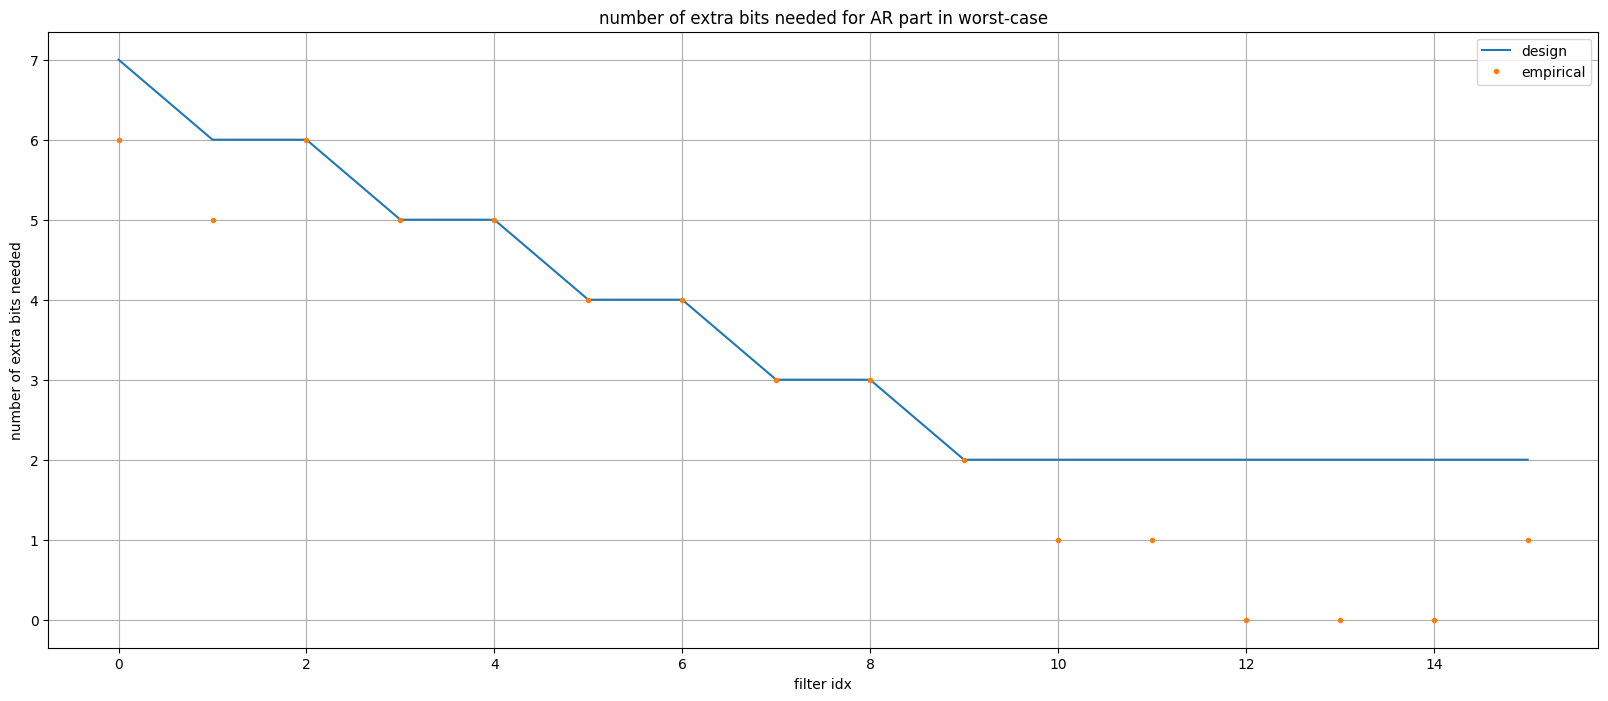

In [ ]:
# required packages

# block-diagram version of the filters
from rockpool.devices.xylo.xylo_a3 import ChipButterworth

# import the ADC module to use the default parameters used in Xylo-A3
from rockpool.devices.xylo.xylo_a3 import PDM_ADC


def test_filterbank_worst_case_chirp():
    """ this is a simple test of filters for a chirp signal. """

    # just to extract the default audio sampling rate
    pdm_adc = PDM_ADC()
    
    # filterbank
    fb = ChipButterworth()
    
    #===========================================================================
    #                            produce a chirp signal
    #===========================================================================
    fmin = 100
    fmax = 20_000
    sample_rate = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    duration = 5
    
    num_samples = int(duration * sample_rate)
    dt = duration/num_samples
    
    # instantenous frequency
    f_inst = np.linspace(fmin, fmax, num_samples)
    phi_inst = 2 * np.pi * np.cumsum(f_inst) * dt
    
    sig_in = np.sin(phi_inst)


    # quantize the signal: additional 4 bits because HW team decided to use 14 bit PDM (compare it with the iriginal 10 bit SAR ADC)
    Q = fb.bd_list[0].B_in + 4
    EPS = 0.00001
    sig_in = (sig_in/(np.max(np.abs(sig_in)) * (1+EPS)) * 2**(Q-1) ).astype(np.int64)
    

    
    #===========================================================================
    #                            Jax version
    #===========================================================================

    sig_out_jax, _, recording_jax = fb(
        sig_in,
        record=True,
        scale_out=True,
    )

    # output of AR part of the filter
    AR_registers = recording_jax["filter_AR_state"][:,:,0]

    # find the maximum amplitude
    max_amplitude = np.max(np.abs(AR_registers), axis=0)

    # compute the worst case amplitude amplification
    chirp_amplitude_amplification = max_amplitude/(2**(Q-1))

    
    # how many extra bits are needed to avoid any over- and under-flow in the filters
    worst_case_extra_bits = np.ceil(np.log2(chirp_amplitude_amplification)).astype(np.int64)

    # remove the effect of B_wf bits added to avoid dead zone in the filter (they are already taken into account)
    worst_case_extra_bits -= np.asarray([bd.B_wf for bd in fb.bd_list])
    
    # what is the designed extra bits
    designed_worst_case_extra_bits = np.asarray([bd.B_worst_case for bd in fb.bd_list])
    
    
    plt.figure(figsize=(20,8))
    plt.plot(designed_worst_case_extra_bits)
    plt.plot(worst_case_extra_bits, ".")
    plt.legend(["design", "empirical"])
    plt.grid(True)
    plt.xlabel("filter idx")
    plt.ylabel("number of extra bits needed")

    plt.title("number of extra bits needed for AR part in worst-case")
    
    plt.show()    

# call the function
test_filterbank_worst_case_chirp() 

## Module 3: Divisive normalization and IAF spike generation
In the previous Xylo-A2, analog circuits were used for filtering and spike generation. Therefore the spikes were completely asynchronous. 
These spikes were then rastered into dyncronous intervals and then was processed by the SNN. There was also a divisive normalization (DN) module that allowed to
normalize the spike rates, which was quite useful when there was time-varying background noise.

Due to asynchronous spikes from the analog part, DN had to be implemented in the spike domain.


In Xylo-A3, all the filters are implemented in digital doamin and are syncronized by the spikes. Also, in contrast with Xylo-A2, the output of the filters is directly available.
This allows to implement DN directly in the filter output before any spike generation. 
This gives better flexibity since filter outputs have a larger dynamic range and can be better averaged out.

We refer to the following documentation to have a better understanding of DN module and why it may needed in audio applications.
There we also explain how the parameters of the should be set for a better performance.

https://spinystellate.office.synsense.ai/research/auditoryprocessing/synchronous-divisive-normalization

In the following we will only provide a higher-level overview of DN.



### Divisive normalization
One of the major problems in audio applicatios is the presence of the background noise (BGN) activity. This is illustrated in the following figure where one can see that the envelopes of the output of the filters vary due to BGN variation. 


<center>
<img src="./figures/dn/sparse_DN.png"  width=50% height=50%>
<figcaption> Fig.1. Illustration of the envolpe of the output signal of a bandpass filter at a given central frequency.<br \> The envelope can be decomposed into signal envelope and background noise envelope. </figcaption>
</center> 

<br />

In practice, BGN varies much more slowly than the audio signal. For example, the frequency pattern of an audio signal has a jumpy pattern with time-width around 10-100 ms whereas the BGN level typically varies within a time-scale of 1-10 seconds.

The main idea of divisive normaliztaion (DN) is to use this property to eliminate the effect of variation of BGN as much as possible.

**Remark.** Typically a high BGN level is not that problematic since it can be easily eliminated by adjusting biases in the SNN that processes the spikes. What is **more problematic** is the variation of the BGN activity with time since it cannot be eliminated by simple bias adjustment in SNN. In theory, one can eliminate BGN by averaging the signal envelope level but this averaging then needs to be done over very long time intervals, which will be quite infeasible in SNN since it requires averaging all the signal samples over windows of length 1-10 second.

In practice, the whole aim of DN can be summarized in the following figure:
- it is seen that before DN, the BGN level varies dramatically with time.
- after DN, the BGN level is almost constant, which makes it very simple to eliminate it using bias-adjustment in the SNN.

<center>
<img src="./figures/dn/bgn_without_dn.png"  width=50% height=50%>
<figcaption> (a) before divisive normalization. </figcaption>

<img src="./figures/dn/bgn_with_dn.png"  width=50% height=50%>
<figcaption> (b) after divisive normalization.  </figcaption>
<br /> 
<figcaption> Fig.2. Illustration of the effect of divisive normalization: Divisive normalization converts the time-varying backgound noise level to a constant level (like white noise) while preserving the spiky signal activity. </figcaption>
</center> 


### How to do divisive normalization?
The generic method for DN is to compute the average to the envelope of the signal and use it as a threshold in spike generation. More specifically, let us denote the envelope of the signal at a specific filter by $E(t)$. To average the envelope we use a low-pass filter $w(t)$, which yields the average $M(t)$ given by 
$$M(t) = E(t) \star w(t) = \int_{0}^\infty w(\lambda) E(t-\lambda) d \lambda .$$
Once this average is computed, we use it as a threshold for spike generation, where the instantenous spike rate is given by 
$$r(t) = \frac{p  E(t) f_s}{M(t) \vee \text{EPS}},$$
where $\text{EPS}$ is a spike activity parameter, where $a \vee b = \max{a,b}$, where $f_s$ is the clock rate of the chip, and where $p$ is a design parameter that adjusts the spike rate to the minimum level needed by the SNN.

Typically, we choose $p=2^{-k}$ to be a power of 2 so that the multiplication can be implemented by $k$ bit shifts.

**Note.** The main idea behind DN is that it is not affected that much by the signal activity since the everaging is done over a much larger window length.


Fortunately the instanteneous spike rate $r(t)$ can be produced via a simple IAF (integrate-and-fire) spike generator with variable spike generation threshold. This is illustrated in the following figure, where one needs to choose the adaptive time-varyiong threshold as 
$$ \text{TH} = \frac{M(t) \vee \text{EPS}}{p}. $$

**Remark.**
To gain an intuition about this formula, note that, if we had a signal with constant envelope $E(t)=E$, then $M(t) \approx E$ and if we set the threshold to $\frac{M(t)\vee \text{EPS}}{p} \approx \frac{E}{p}$, every $\frac{1}{p}$ clock period the IAF counter accumulative evalue will be around $\frac{E}{p}$, thus, of the same value of the spike generation thresold. This implies that every $\frac{1}{p}$ clock period, one spike will be produced. This implies that the spike rate will be $p f_s$, which would be compatible with $\text{TH} = \frac{p E(t) f_s}{M(t) \vee \text{EPS}}$ with $E(t)=M(t)=E$.
<br /> 


**Remark.** 
In the current version, we are using a $p=\frac{1}{2^b}$ so that we can use $M(t)\vee EPS \ll b$ as the spike generation threshold.

Let us investigate this module via some practical examples.

### Example 1: Background noise with amplitude jump
We assume that the signal is a sinusoid and study two scenarios where the amplitude of the backgroun nosue makes an abrupt change. 
One can imagine a street where car noises go up and down as they come closer or far away from the microphone.

We illustrate this via a 2-channel signal where channel-1 adn channel-2 have up- and down-jump in their amplitude level.
If the DN module works properly, we expact that after some transition time, the rate of produced spikes should reach the target spike rate designed for/enforced by DN module.

We set the length of the DN filter used for estinating the average power to 100 x period of the sinusoid.

Also we set the rate scale bit shift parameter to 10 such that with an input sample rate of 48000 we obtain $\frac{48000}{2^{10}} \approx 48$ spike/sec for the spike rate.


It is seen from the simulation results that DN immediately adapts its spike-generation threshold to keep the spike rate due to background noise around the target 48 spike/sec.
From this perspective, we can consider DN as CFAR (constant false-alarm rate) detector in the sense that it makes sure that the noise level is always constant such that 
false alarms due to noise are under control. 

/Users/haghighat/SynSense Dropbox/Saeid Haghighatshoar/Projects/Xylo-A3-Sim/xylo-a3-simulator/xylo_a3_sim/pdm_adc.py:525: UserWarning: filter cutoff-width was unset in the implementation to futher lower-down the tail response!
  warnings.warn(


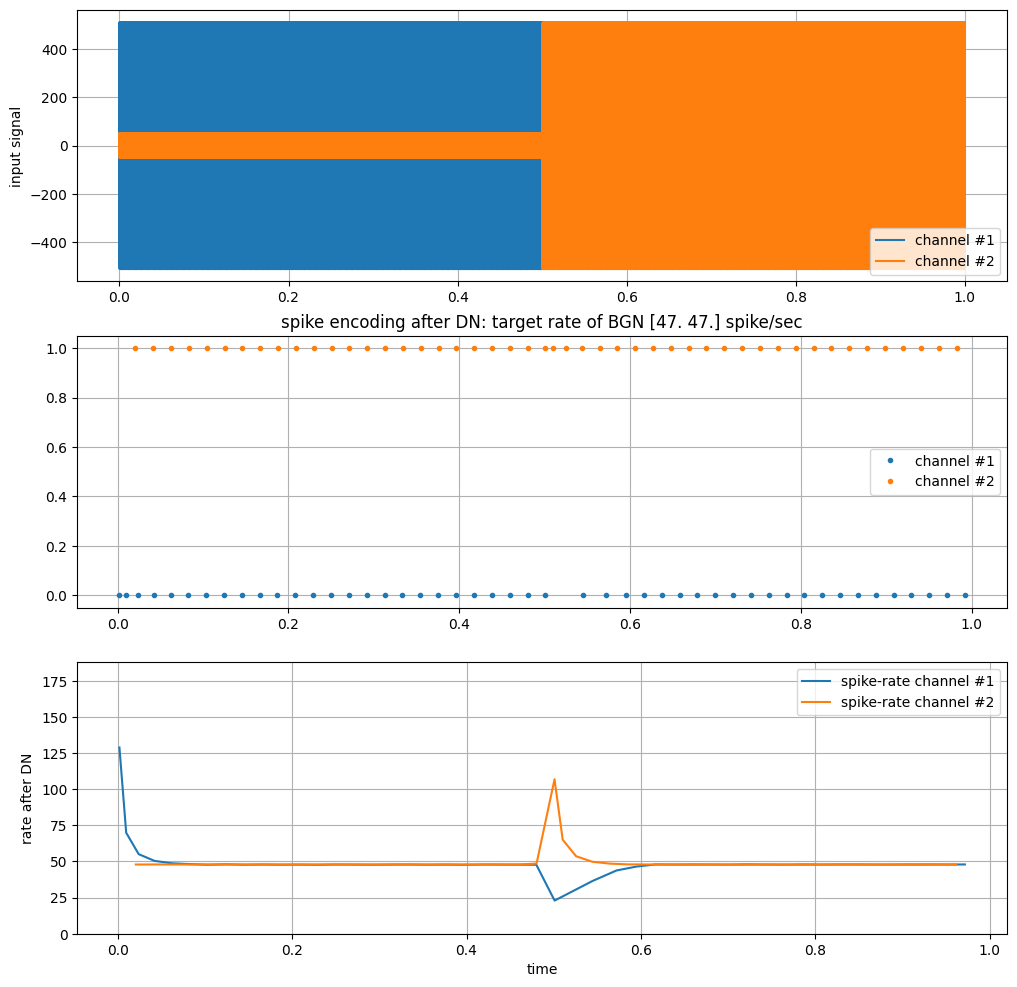

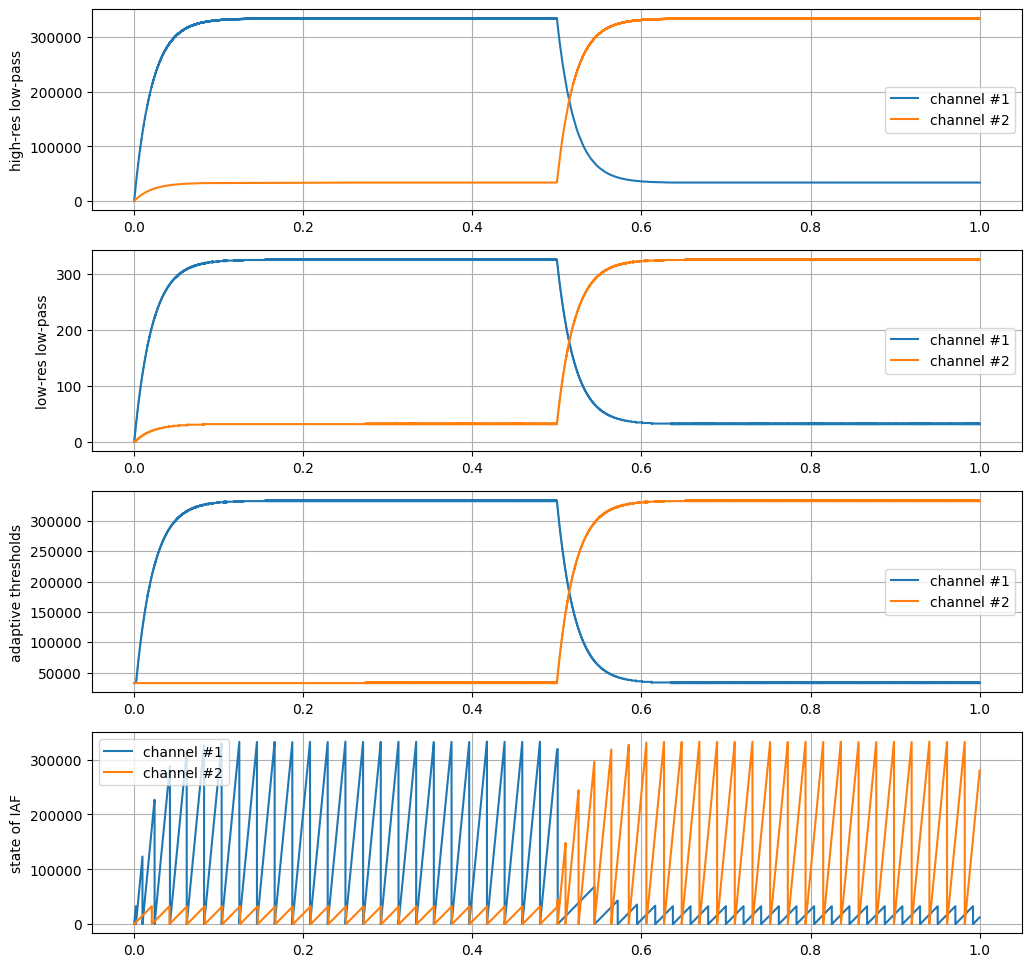

In [ ]:
# required packages
import numpy as np
import matplotlib.pyplot as plt

from rockpool.devices.xylo.xylo_a3 import DivisiveNormalization

from rockpool.timeseries import TSContinuous

from rockpool.devices.xylo.xylo_a3 import PDM_ADC
from rockpool.devices.xylo.xylo_a3 import ChipButterworth



def test_DN_performance_with_BGN():
    """
    This function checks how DN reduces the BGN level to an almost constant level independent of how strong it may get.
    """
    pdm_adc = PDM_ADC()
    
    # sample rate
    fs = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    num_bits_in = 10
    
    f0 = 4_000
    
    duration = 1
    time = np.arange(0, duration, step=1/fs)
    
    # vary the value of the amplitude
    amplitude = np.zeros_like(time)
    amplitude[:len(amplitude)//2] = 1.0
    amplitude[len(amplitude)//2:] = 0.1
    
    sig_in_ch1 = amplitude * np.sin(2*np.pi * f0 * time)
    sig_in_ch2 = amplitude[-1::-1] * np.cos(2 * np.pi * f0 *time)
    
    sig_in = np.vstack([sig_in_ch1, sig_in_ch2]).T
    
    
    # quantize the signal
    sig_in_q = (sig_in/(np.max(np.abs(sig_in)) * 1.000001) * 2**(num_bits_in-1)).astype(np.int64)
    
    #-- build the DN module
    num_channels = sig_in_q.shape[1]
    
    # averaging window length
    num_periods = 100
    avg_window_duration = num_periods/f0
    avg_window_len = int(fs * avg_window_duration)
    low_pass_bitshift = int(np.log2(avg_window_len))
    
    # how to set the target spike rate in steady state?
    # to have on average fs/(2^10-1) = 48K/1000 = 40 ~ 50 spikes/sec in the presence of BGN activity
    spike_rate_scale_bitshift1 = 10 
    spike_rate_scale_bitshift2 = 0

    # lower bound on the threshold
    EPS = 32

    dn = DivisiveNormalization(
        num_channels,
        spike_rate_scale_bitshift1=spike_rate_scale_bitshift1,
        spike_rate_scale_bitshift2=spike_rate_scale_bitshift2,
        low_pass_bitshift=low_pass_bitshift,
        EPS_vec=EPS,
        fs=fs,
    )
    
    # do we have seperate or joint spike rate scaling?
    dn.joint_normalization = np.repeat(False, num_channels)
    spikes, _, recording = dn(
        sig_in_q,
        record=True,
    )
    
    
    #############################################################################
    #############################################################################
    
    # plot the results
    plt.figure(figsize=(12,12))
    plt.subplot(311)
    plt.plot(time, sig_in_q)
    plt.grid(True)
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('input signal')
    
    plt.subplot(312)
    for i, spk in enumerate(spikes.T):
        time_spk = time[spk==1]
        plt.plot(time_spk, i * np.ones_like(time_spk), '.')
        
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.grid(True)
    
    plt.title(f'spike encoding after DN: target rate of BGN {(dn.fs //(2**dn.spike_rate_scale_bitshift1 - 2**dn.spike_rate_scale_bitshift2))} spike/sec')
    
    
    plt.subplot(313)
    for i, spk in enumerate(spikes.T):
        time_spk = time[spk==1]
        rate_spk = 1/np.diff(time_spk)
        plt.plot(time_spk[:-1], rate_spk)
    
    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('rate after DN')
    
    max_spike_rate = max(4*(dn.fs //(2**dn.spike_rate_scale_bitshift1 - 2**dn.spike_rate_scale_bitshift2)))
    plt.ylim([0, max_spike_rate])
    plt.legend([f'spike-rate channel #{i}' for i in [1,2]])
        
    
    plt.grid(True)
    plt.show(block=False)
    
    # plot the states
    plt.figure(figsize=(12,12))
    plt.subplot(411)
    plt.plot(time, recording['state_high_res_filter'])
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('high-res low-pass')
    plt.grid(True)
    
    plt.subplot(412)
    plt.plot(time, recording['state_low_res_filter'])
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('low-res low-pass')
    plt.grid(True)

    
    plt.subplot(413)
    plt.plot(time, recording['spike_gen_thresholds'])  
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('adaptive thresholds')
    plt.grid(True)  

    plt.subplot(414)
    plt.plot(time, recording['state_IAF'])  
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('state of IAF')
    plt.grid(True)  
    
    plt.show()
        

# call the function
test_DN_performance_with_BGN()



### Example 1: Relative Scaling Issue with DN and How to Fix it
As you may have noticed, the DN in the current form has the issue that it normalizes the spike rate of all channels to a preset value. This implies that it destroys the relative scaling
of spike rates across various channels. 

Ideally, we would like to keep this relative rate since it contains useful information for classification. 
This relative spike rate can be preserved by setting the flag `joint_normalization` in the `evolve` function in DN. This is illustrated in the following simulation.

It is seen that after setting this flag, the relative scaling of spike rate is preserved across various channels. Also, the spike rate due to background noise is always kept below the target rate 40 ~ 50 spike/sec.

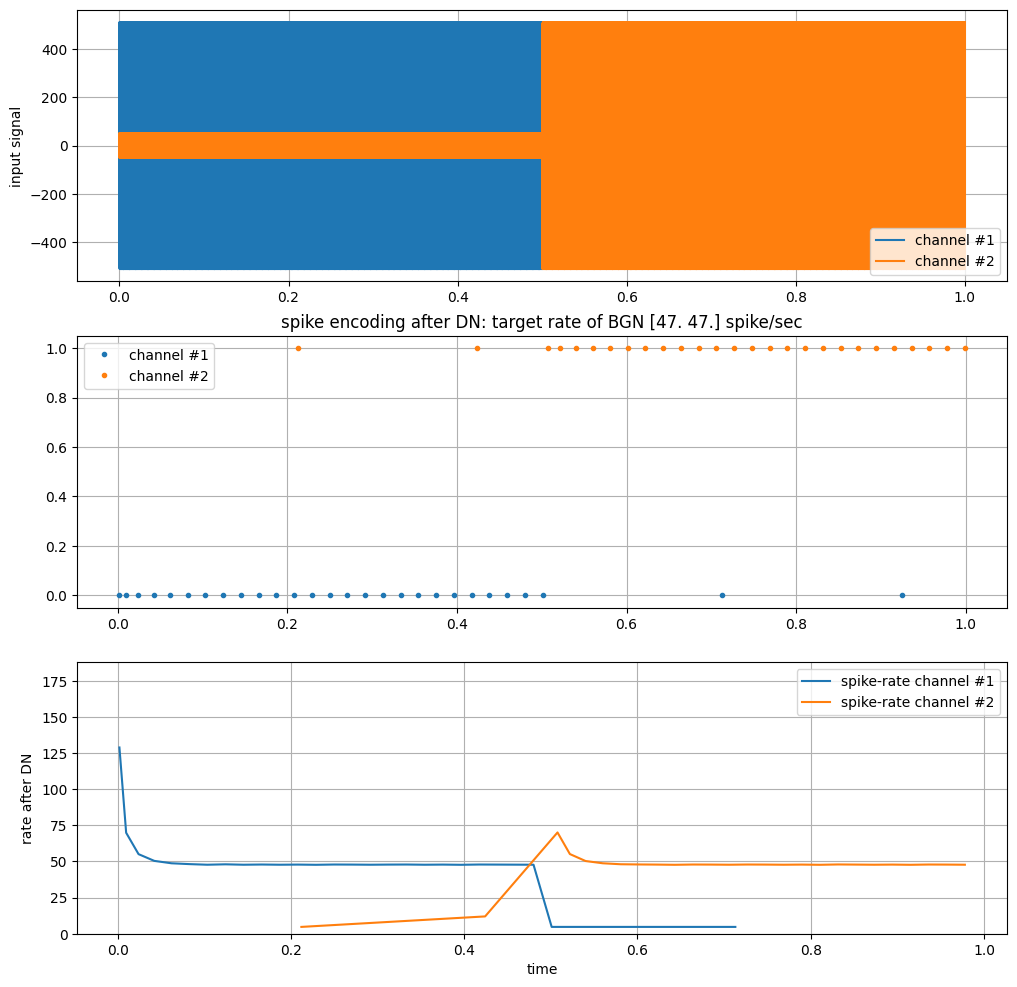

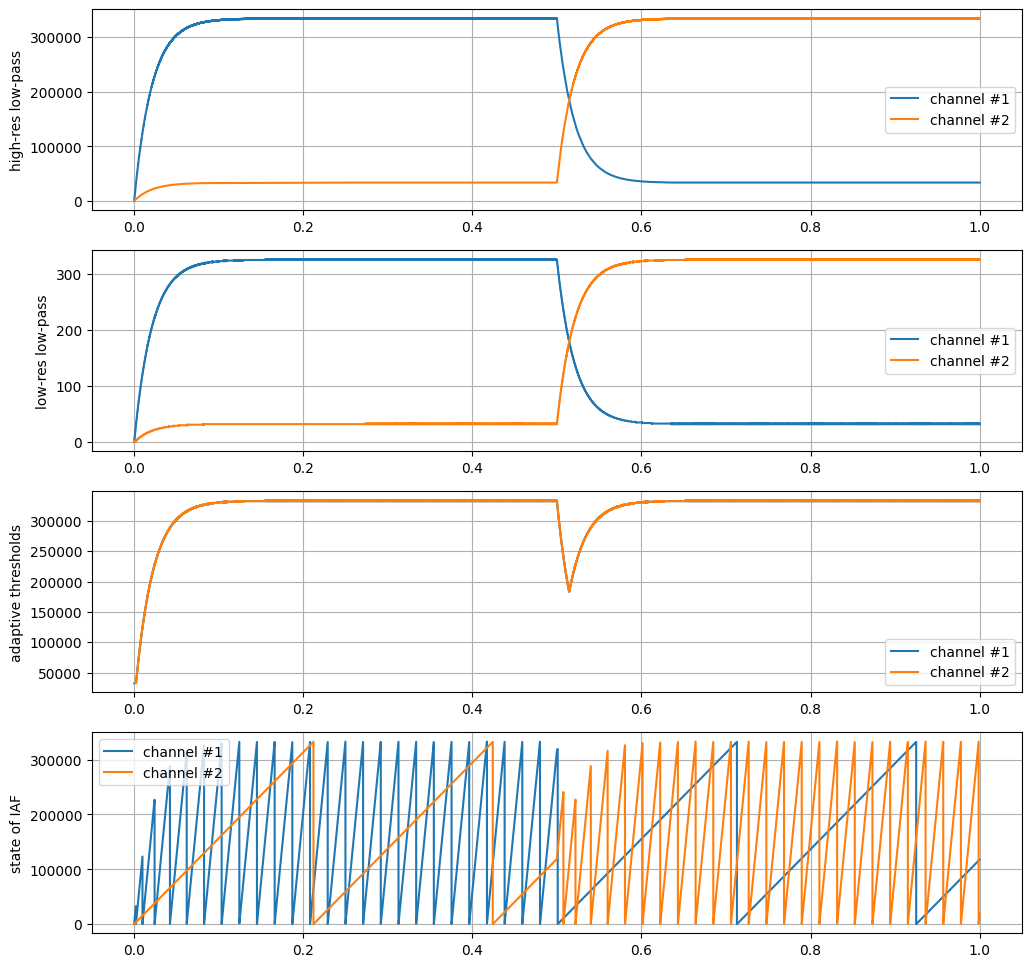

In [ ]:
# required packages
import numpy as np
import matplotlib.pyplot as plt

from rockpool.devices.xylo.xylo_a3 import DivisiveNormalization

from rockpool.timeseries import TSContinuous

from rockpool.devices.xylo.xylo_a3 import PDM_ADC
from rockpool.devices.xylo.xylo_a3 import ChipButterworth



def test_DN_performance_with_BGN():
    """
    This function checks how DN reduces the BGN level to an almost constant level independent of how strong it may get.
    """
    pdm_adc = PDM_ADC()
    
    # sample rate
    fs = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    num_bits_in = 10
    
    f0 = 4_000
    
    duration = 1
    time = np.arange(0, duration, step=1/fs)
    
    # vary the value of the amplitude
    amplitude = np.zeros_like(time)
    amplitude[:len(amplitude)//2] = 1.0
    amplitude[len(amplitude)//2:] = 0.1
    
    sig_in_ch1 = amplitude * np.sin(2*np.pi * f0 * time)
    sig_in_ch2 = amplitude[-1::-1] * np.cos(2 * np.pi * f0 *time)
    
    sig_in = np.vstack([sig_in_ch1, sig_in_ch2]).T
    
    
    # quantize the signal
    sig_in_q = (sig_in/(np.max(np.abs(sig_in)) * 1.000001) * 2**(num_bits_in-1)).astype(np.int64)
    
    #-- build the DN module
    num_channels = sig_in_q.shape[1]
    
    # averaging window length
    num_periods = 100
    avg_window_duration = num_periods/f0
    avg_window_len = int(fs * avg_window_duration)
    low_pass_bitshift = int(np.log2(avg_window_len))
    
    # how to set the target spike rate in steady state?
    # to have on average fs/(2^10-1) = 48K/1000 = 40 ~ 50 spikes/sec in the presence of BGN activity
    spike_rate_scale_bitshift1 = 10 
    spike_rate_scale_bitshift2 = 0

    # lower bound on the threshold
    EPS = 32

    dn = DivisiveNormalization(
        num_channels,
        spike_rate_scale_bitshift1=spike_rate_scale_bitshift1,
        spike_rate_scale_bitshift2=spike_rate_scale_bitshift2,
        low_pass_bitshift=low_pass_bitshift,
        EPS_vec=EPS,
        fs=fs,
    )
    
    # do we have seperate or joint spike rate scaling?
    dn.joint_normalization = np.repeat(True, num_channels)
    
    spikes, _, recording = dn.evolve(
        sig_in_q,
        record=True,
    )
    
    
    #############################################################################
    #############################################################################
    
    # plot the results
    plt.figure(figsize=(12,12))
    plt.subplot(311)
    plt.plot(time, sig_in_q)
    plt.grid(True)
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('input signal')
    
    plt.subplot(312)
    for i, spk in enumerate(spikes.T):
        time_spk = time[spk==1]
        plt.plot(time_spk, i * np.ones_like(time_spk), '.')
        
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.grid(True)
    
    plt.title(f'spike encoding after DN: target rate of BGN {(dn.fs //(2**dn.spike_rate_scale_bitshift1 - 2**dn.spike_rate_scale_bitshift2))} spike/sec')
    
    
    plt.subplot(313)
    for i, spk in enumerate(spikes.T):
        time_spk = time[spk==1]
        rate_spk = 1/np.diff(time_spk)
        plt.plot(time_spk[:-1], rate_spk)
    
    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('rate after DN')
    
    max_spike_rate = max(4*(dn.fs //(2**dn.spike_rate_scale_bitshift1 - 2**dn.spike_rate_scale_bitshift2)))
    plt.ylim([0, max_spike_rate])
    plt.legend([f'spike-rate channel #{i}' for i in [1,2]])
        
    
    plt.grid(True)
    plt.show(block=False)
    
    # plot the states
    plt.figure(figsize=(12,12))
    plt.subplot(411)
    plt.plot(time, recording['state_high_res_filter'])
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('high-res low-pass')
    plt.grid(True)
    
    plt.subplot(412)
    plt.plot(time, recording['state_low_res_filter'])
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('low-res low-pass')
    plt.grid(True)

    
    plt.subplot(413)
    plt.plot(time, recording['spike_gen_thresholds'])  
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('adaptive thresholds')
    plt.grid(True)  

    plt.subplot(414)
    plt.plot(time, recording['state_IAF'])  
    plt.legend([f'channel #{i}' for i in [1,2]])
    plt.ylabel('state of IAF')
    plt.grid(True)  
    
    plt.show()
        

# call the function
test_DN_performance_with_BGN()



### Example 2: Background noise and signal
In this part, we assume that the amplitude of the background noise changes very slowly according to a harmonic pattern.
Also, we assume that we have also a sigal whose transition shappen much faster than the background noise. 
This is for example the case in speech/audio signal where the signal pattern in each frequency channel is quite jumpy/spiky as the corresponding frequencies appear and disappear.

In this simulation:
- we should set the signal-to-noise-ratio (SNR). Here we will work with a local notion of SNR, namely, how large signal is compared with noise when they are both present within a short interval. 
Using a time-averaged notion of SNR will not be useful here since signal is so spiky in time and also we care about the variation in spike rate due to signal only when it is present.
- we assume that the local SNR is aroudn 10 dB and investigate how the produced spike rate varies when we drop the SNR.


As we can see from the simulation results:
- DN is able to reduce the spike rate to around 50 spike/sec target rate for background noise.
- DN keeps the relative ratio between signal and background noise spike rate. 
  

There is a critical issue about DN that one should be aware of. Here, after normalization we said that the spike rate due to background noise is normalized to the target rate (here 50 spike/sec) at which we are sure
no false-alarm will happen.

This of course makes sense when the background noise is quite large. But what if the background noise is very low? Then it does not make sense to normalize it because we do not want to artificially amplify the backgroun noise.

here, the lower bound on threshold $EPS$ is quite useful. We can set this for each channel seperately depending on the backround noise power level. When the background noise is so weak that its average power is below $EPS$, it is almost eliminated and no normalization happens. However, we should not use a very large value for $EPS$ because then it may eliminate the spiky signal as well.


This can be see in the last figure in the simulation. Here what we do is that we set the lower bound $EPS=16$ and for the given SNR, we scale both signal and background noise by a scale parameter. We can see from the results that as fasr as theis scale is large enough
after DN, the background noise spike rate is normalized and the spike rate due to signal also remains stable. 

However, if we keep reducing the spike further, background noise and later the signal are eliminated.



/Users/haghighat/SynSense Dropbox/Saeid Haghighatshoar/Projects/Xylo-A3-Sim/xylo-a3-simulator/xylo_a3_sim/pdm_adc.py:525: UserWarning: filter cutoff-width was unset in the implementation to futher lower-down the tail response!
  warnings.warn(


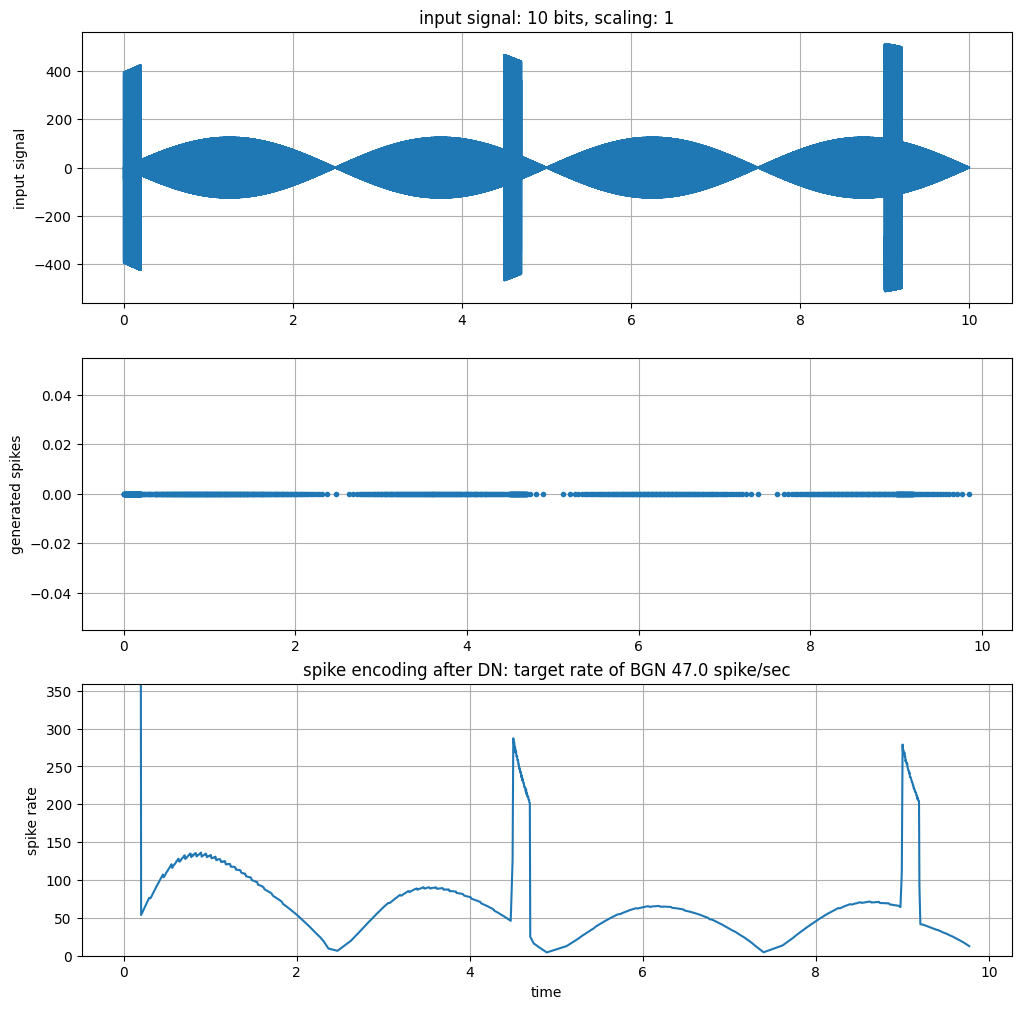

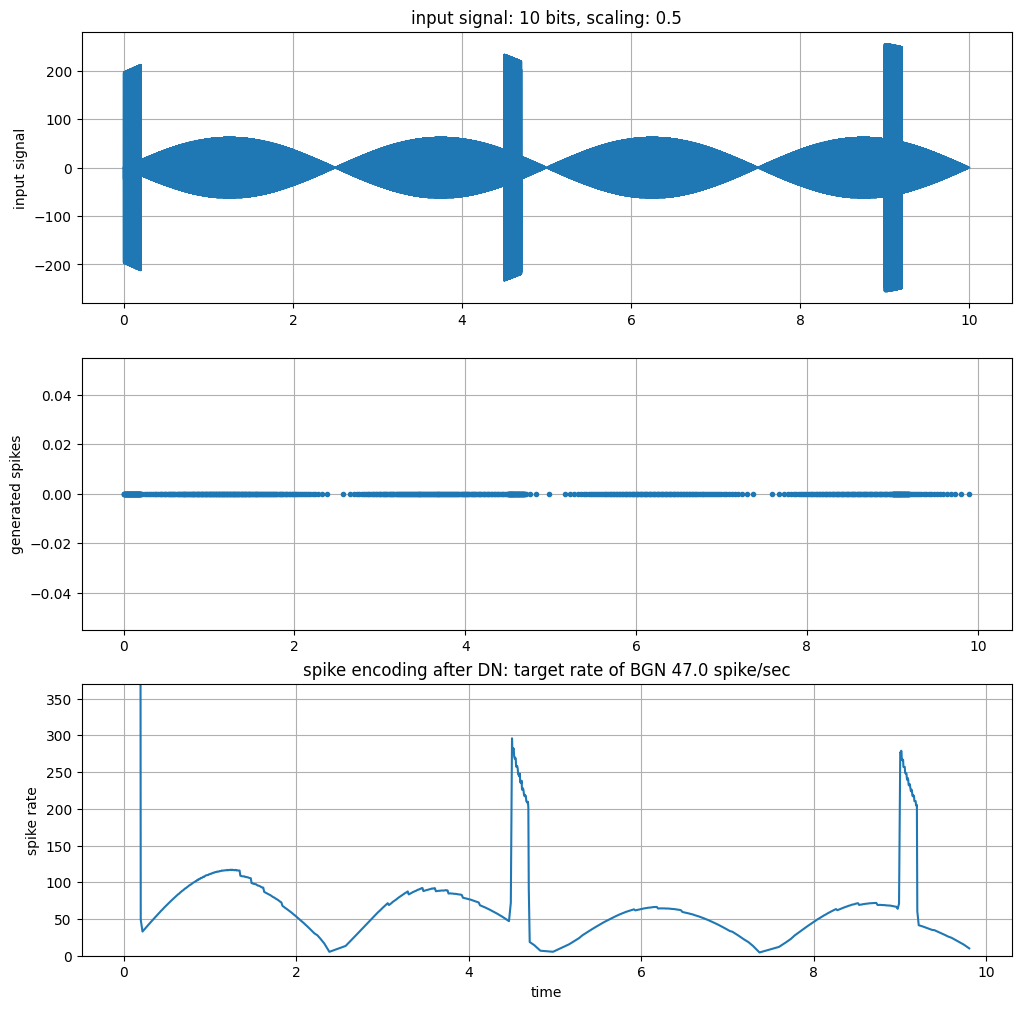

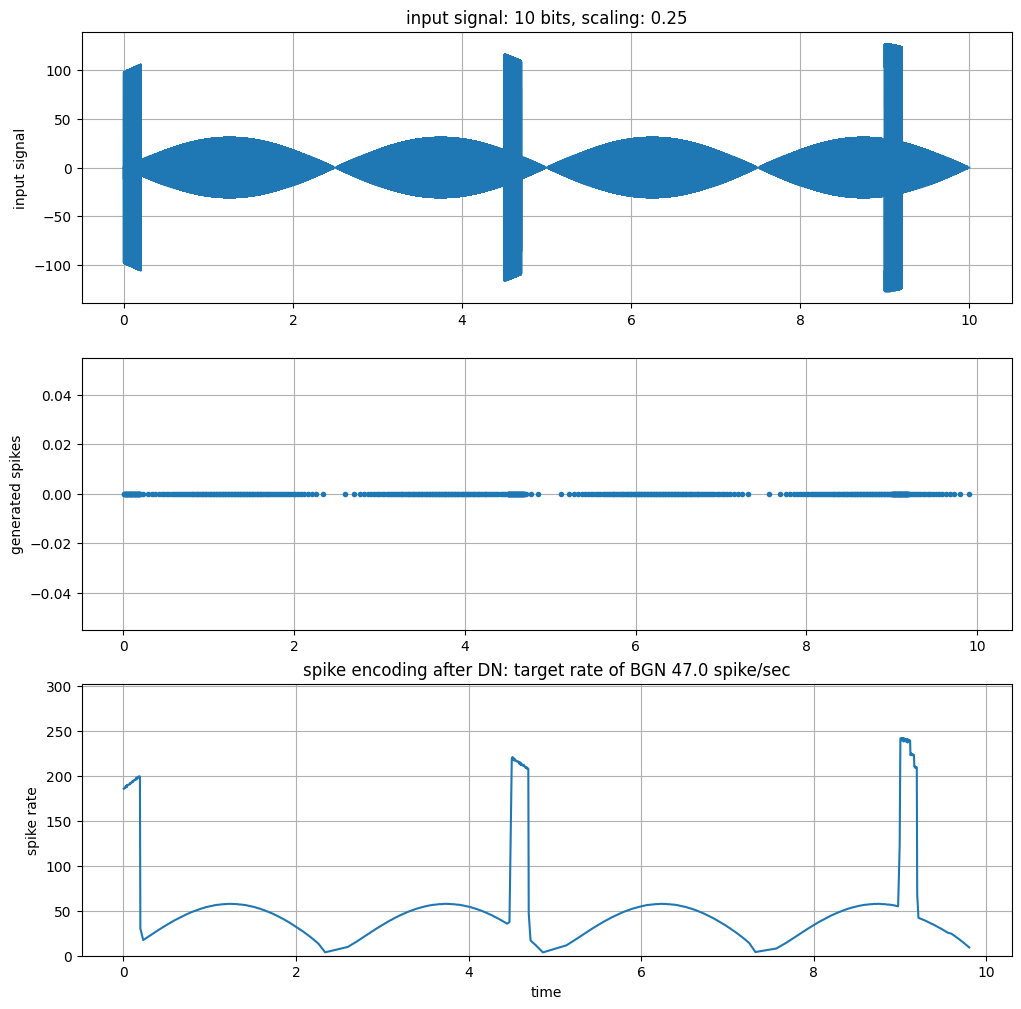

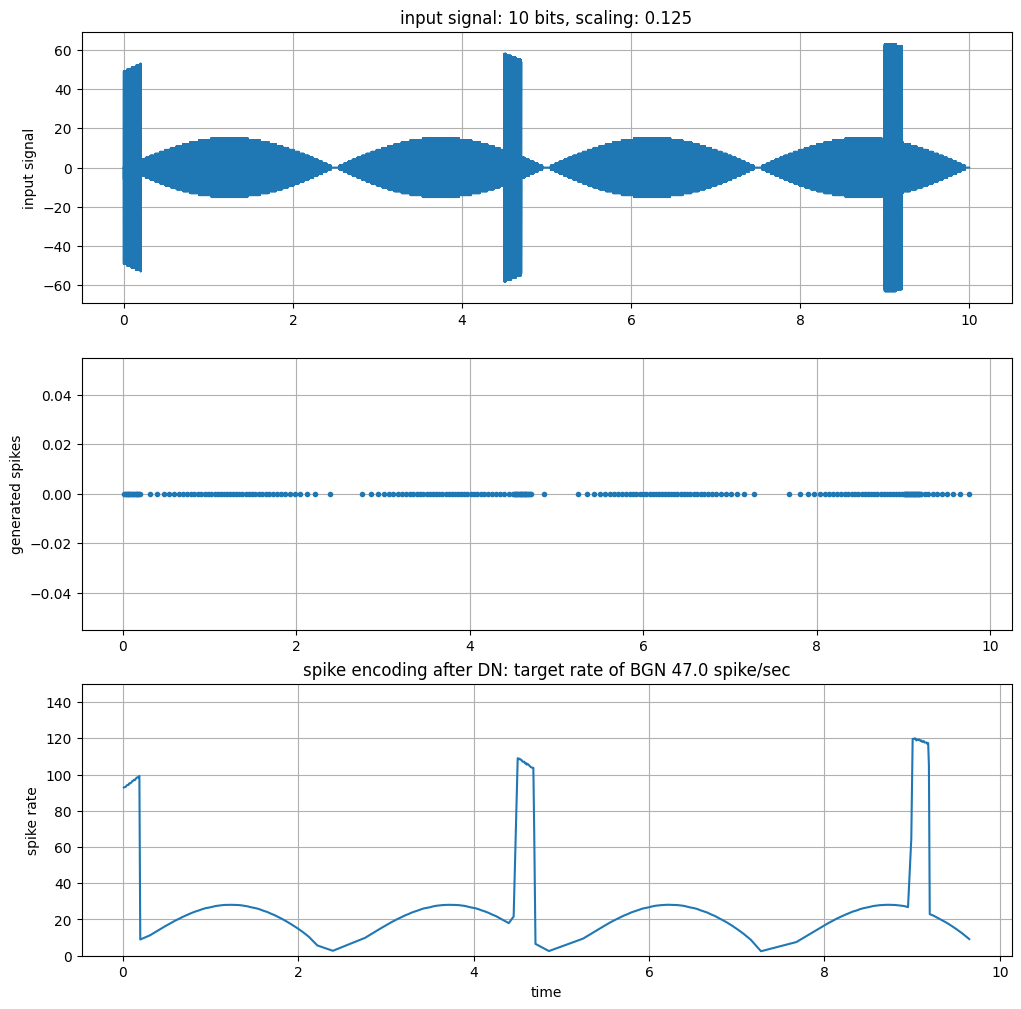

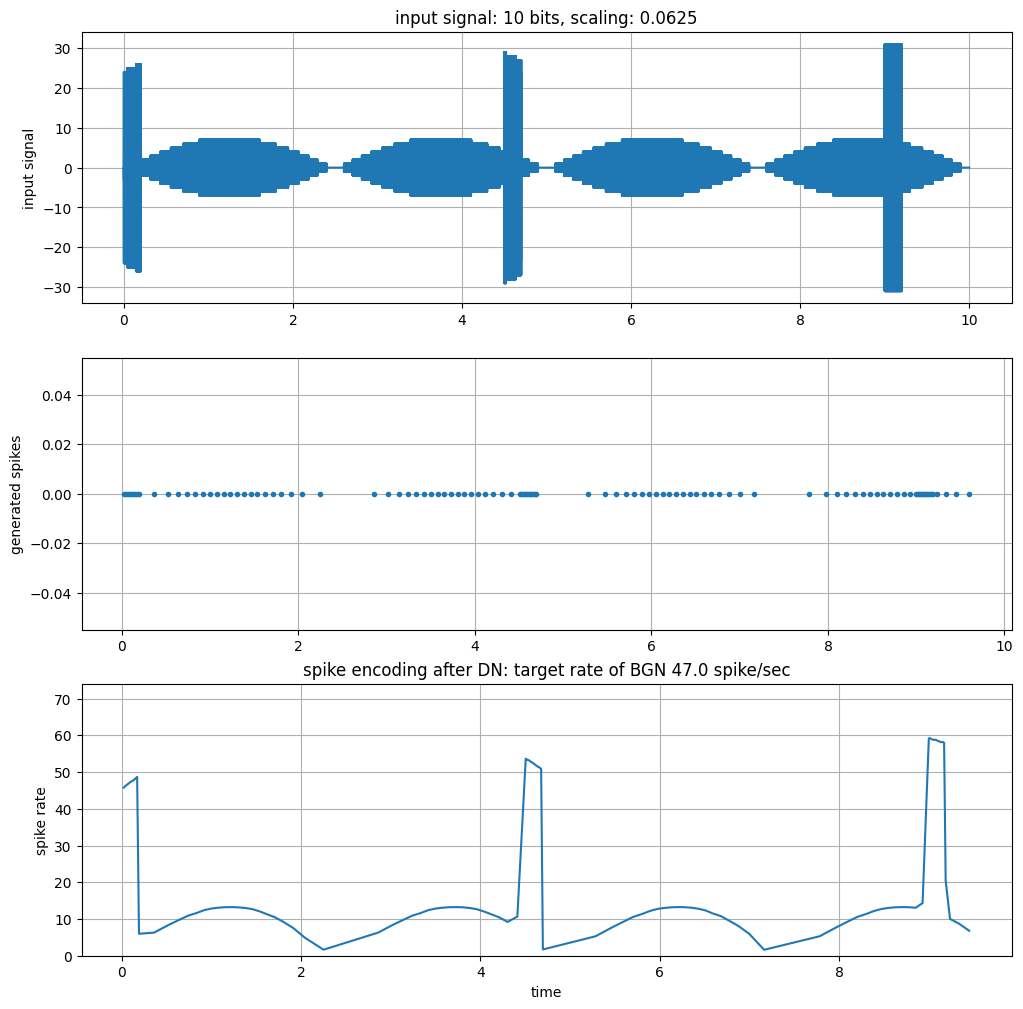

In [ ]:
# required packages
import numpy as np
import matplotlib.pyplot as plt

from rockpool.devices.xylo.xylo_a3 import DivisiveNormalization

from rockpool.timeseries import TSContinuous

from rockpool.devices.xylo.xylo_a3 import PDM_ADC
from rockpool.devices.xylo.xylo_a3 import ChipButterworth



def test_DN_performance_with_Signal():
    """
    This function checks how DN acts in the presence of signal with varying background level noise.
    """
    #===========================================================================
    #   build a power evelope of the signal with 
    #       (i)     slowly varying BGN
    #       (ii)    impulsive and spiky siganl activity
    #===========================================================================

    pdm_adc = PDM_ADC()
    
    # sample rate
    fs = pdm_adc[0].fs/pdm_adc[0].sdm_OSR
    num_bits_in = 10
    f0 = 4_000
    duration = 10
    time = np.arange(0, duration, step=1/fs)
    
    
    # signal envelope
    sig_envelope_window = 0.02 * duration
    sig_envelope_period = 0.45 * duration
    
    ts_time_vec = [0.0, sig_envelope_window/1000, sig_envelope_window, 1.001 * sig_envelope_window, sig_envelope_period]
    ts_envelope_vec = [0.0, 1.0, 1.0, 0.0, 0.0]
    
    ts_signal = TSContinuous(
        times=ts_time_vec,
        samples=ts_envelope_vec,
        periodic=True,
    )
    
    sig_envelope = ts_signal(time).squeeze()
    
    # bachground noise envelope
    snr_db = 10.0
    snr = 10**(snr_db/10)
    
    num_bgn_envelope_period = 4
    bgn_envelope = np.max(sig_envelope)/np.sqrt(snr) * np.abs(np.sin(np.pi*time/duration * num_bgn_envelope_period))
    
    
    # total signal envelope
    envelope = sig_envelope + bgn_envelope
    
    # create the signal with the given envelope
    sig_in = envelope * np.sin(2*np.pi*f0*time)
    
    # quantize the signal
    sig_in_q = (sig_in/(np.max(np.abs(sig_in)) * 1.000001) * 2**(num_bits_in-1)).astype(np.int64)

    
    #-- process the signal with DN
    # window size of the signal
    sig_window_len = int(fs * sig_envelope_window)
    avg_window_len = 16 * sig_window_len
    low_pass_bitshift = round(np.log2(avg_window_len))
    
    # how to set the target spike rate in steady state?
    # to have on average fs/(2^10-1) = 48K/1000 = 40 ~ 50 spikes/sec in the presence of BGN activity
    spike_rate_scale_bitshift1 = 10 
    spike_rate_scale_bitshift2 = 0
    
    
    EPS = 16
    dn = DivisiveNormalization(
        1,
        spike_rate_scale_bitshift1= spike_rate_scale_bitshift1,
        spike_rate_scale_bitshift2= spike_rate_scale_bitshift2,
        low_pass_bitshift=low_pass_bitshift,
        EPS_vec=EPS,
        fs=fs,
    )
    
    
    # possible scalings of the input signal
    scale_list = [1, 1/2, 1/4, 1/8, 1/16]
    
    for scale in scale_list:
        # scale the quantized input signal
        sig_scale = (scale * sig_in_q).astype(np.int64).astype(sig_in_q.dtype)

        spikes, _, recording = dn.evolve(
            sig_scale.reshape(-1,1),
            record=True,
        )
        
        
        # plot the results
        plt.figure(figsize=(12,12))
        plt.subplot(311)
        plt.plot(time, sig_scale.T)
        plt.grid(True)
        plt.ylabel('input signal')
        plt.title(f'input signal: {num_bits_in} bits, scaling: {scale}')
        
        plt.subplot(312)
        time_spk = time[spikes==1]
        plt.plot(time_spk, np.zeros_like(time_spk), '.')
        plt.ylabel('generated spikes')
        plt.grid(True)
        
        plt.subplot(313)
        rate_spk = 1/np.diff(time_spk)
        plt.plot(time_spk[:-1], rate_spk)
        plt.xlabel('time')
        plt.ylabel('spike rate')
        plt.grid(True)
        plt.title(f'spike encoding after DN: target rate of BGN {(fs // (2**spike_rate_scale_bitshift1 - 2**spike_rate_scale_bitshift2))} spike/sec')
        
        max_spike_rate = np.max(rate_spk[len(rate_spk)//2:])
        
        plt.ylim([0,1.25*max_spike_rate])
        
        plt.show(block=False)
    
# call the function
test_DN_performance_with_Signal()